In [ ]:
import pandas as pd
import numpy as np

# 1. Load your data
df = pd.read_csv('data2.csv')

# 2. Define the “malicious” condition:
#    Src IP == 192.168.168.59
# AND Dst IP == 192.168.168.136
# AND Dst Port is either 80 or 443
cond = (
    (df['Src IP']  == '192.168.195.59') &
    (df['Dst IP']  == '192.168.195.136') &
    (df['Dst Port'].isin([80, 443]))
)

# 3. Create the Label column
df['Label'] = np.where(cond, 'malicious', 'normal')

# 4. (Optional) Quick sanity check:
print(df['Label'].value_counts())

# 5. Save your newly labeled data
df.to_csv('labeled_data.csv', index=False)


Label
malicious    3403
normal        968
Name: count, dtype: int64


<ipython-input-4-4b484ba72663>:16: UserWarning: Parsing dates in %d/%m/%Y %I:%M:%S %p format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  combined_df['Timestamp'] = pd.to_datetime(combined_df['Timestamp'])


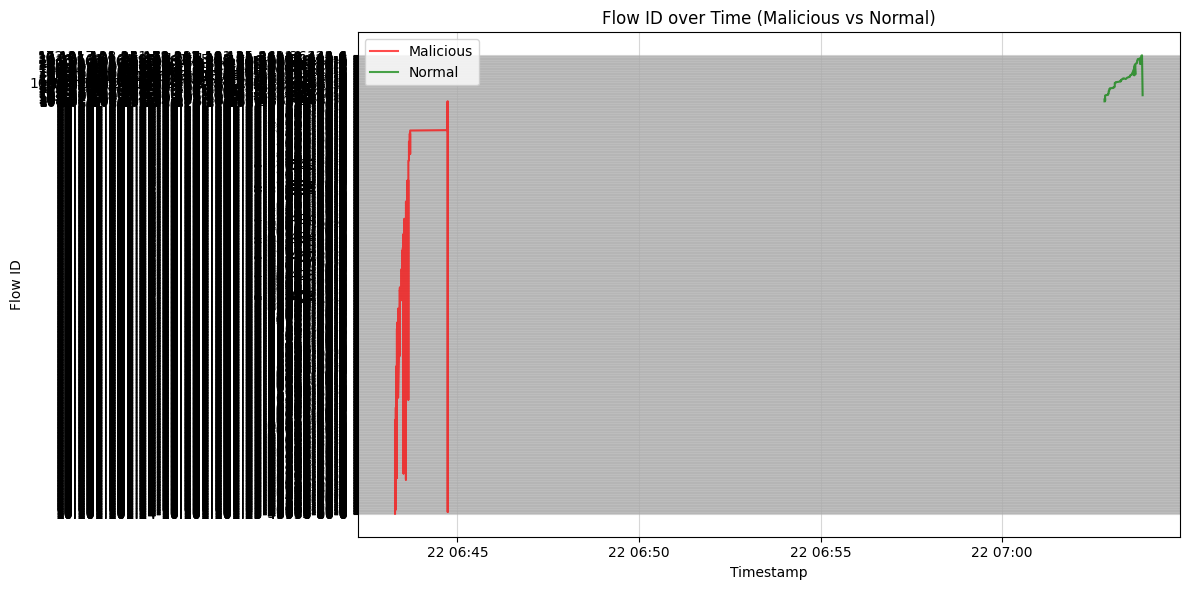

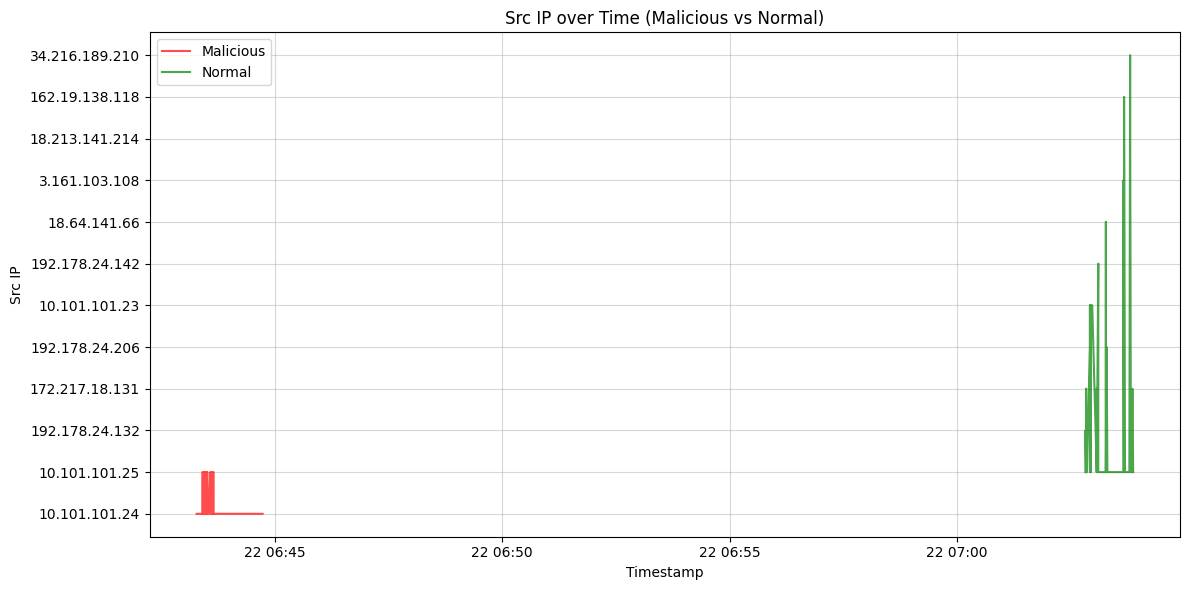

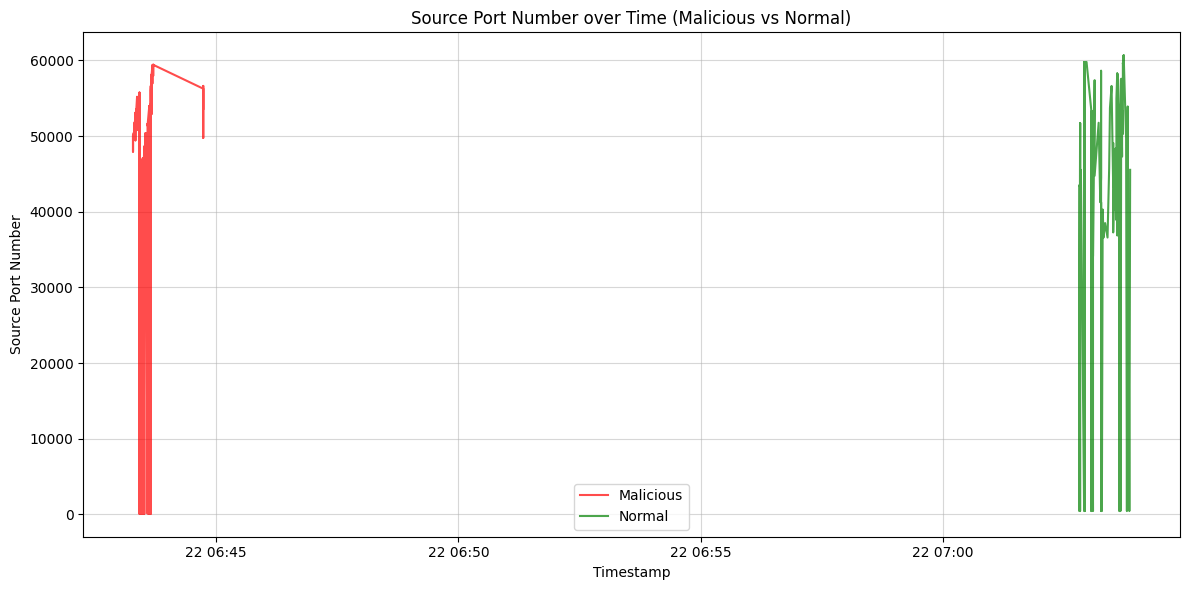

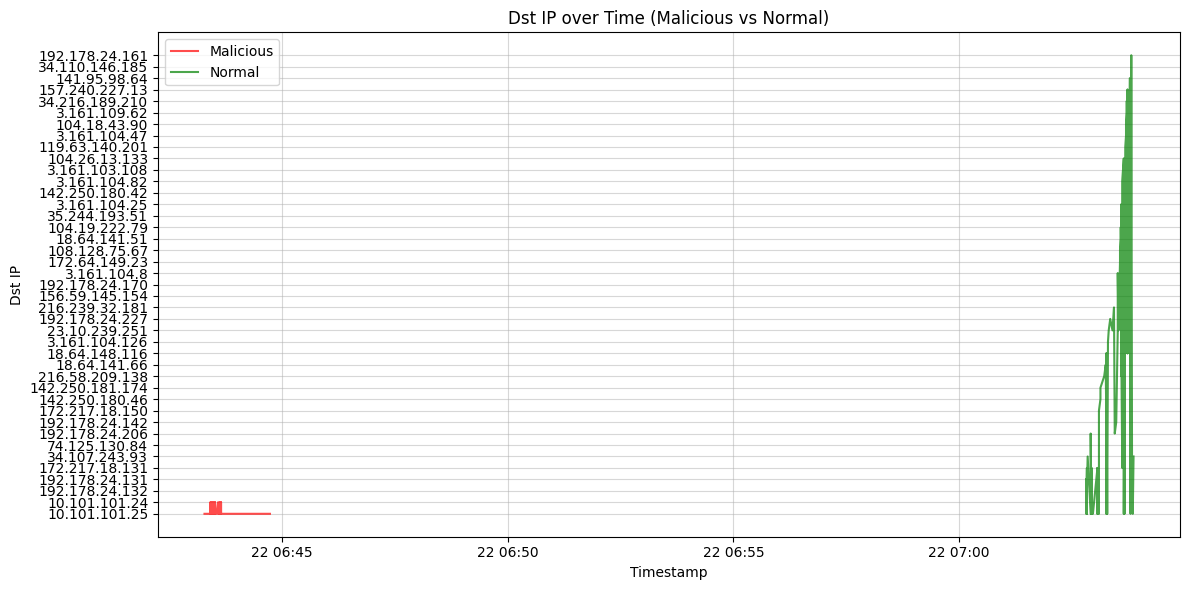

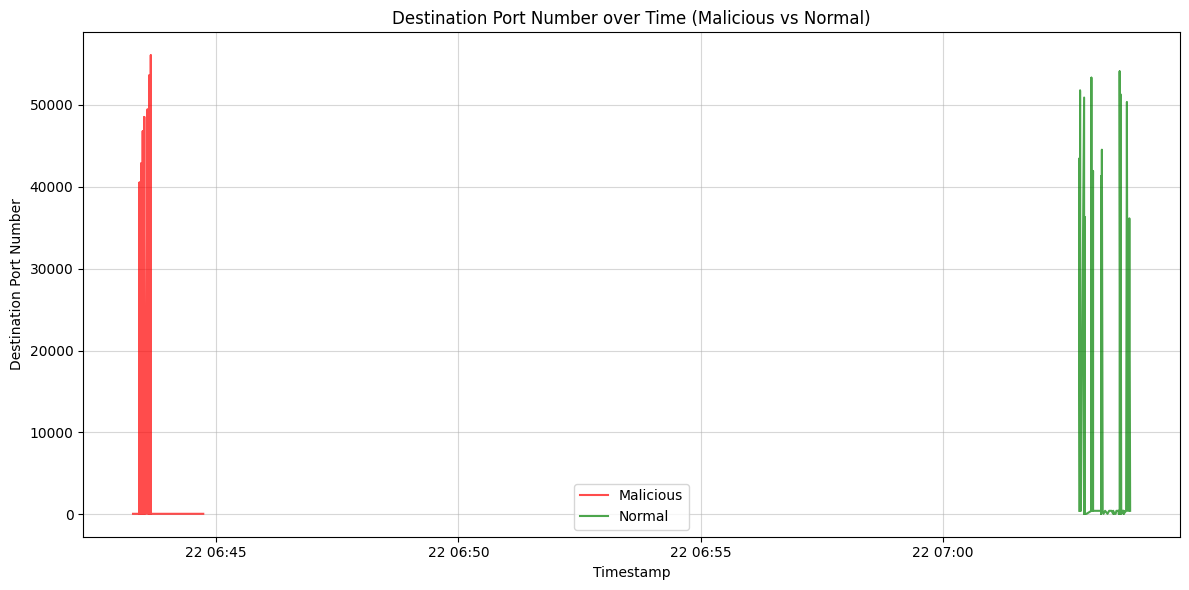

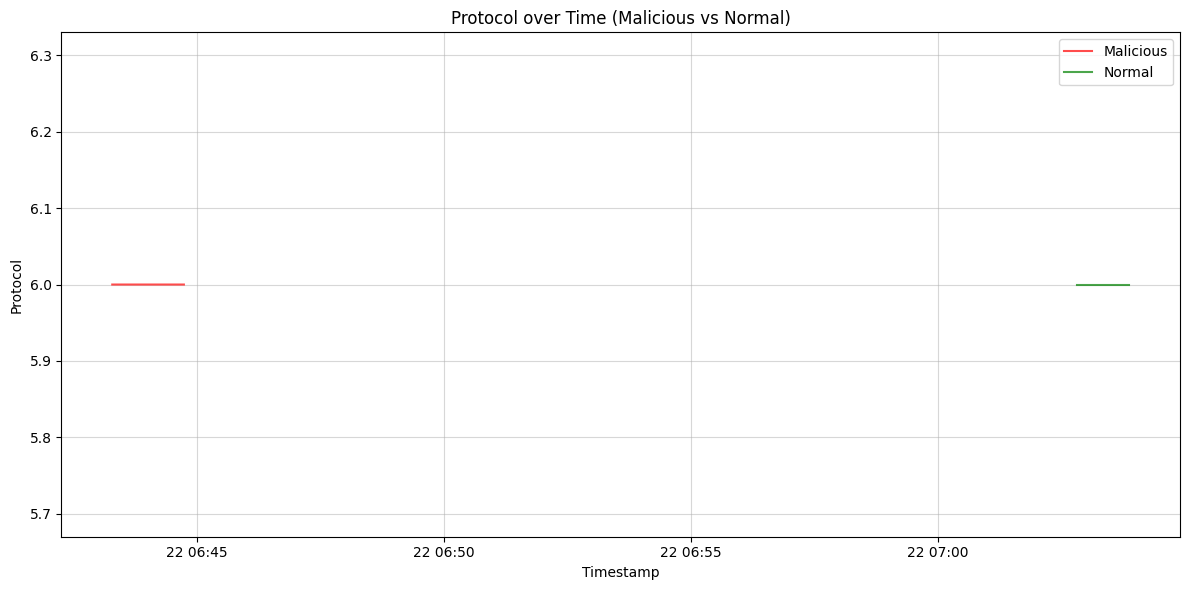

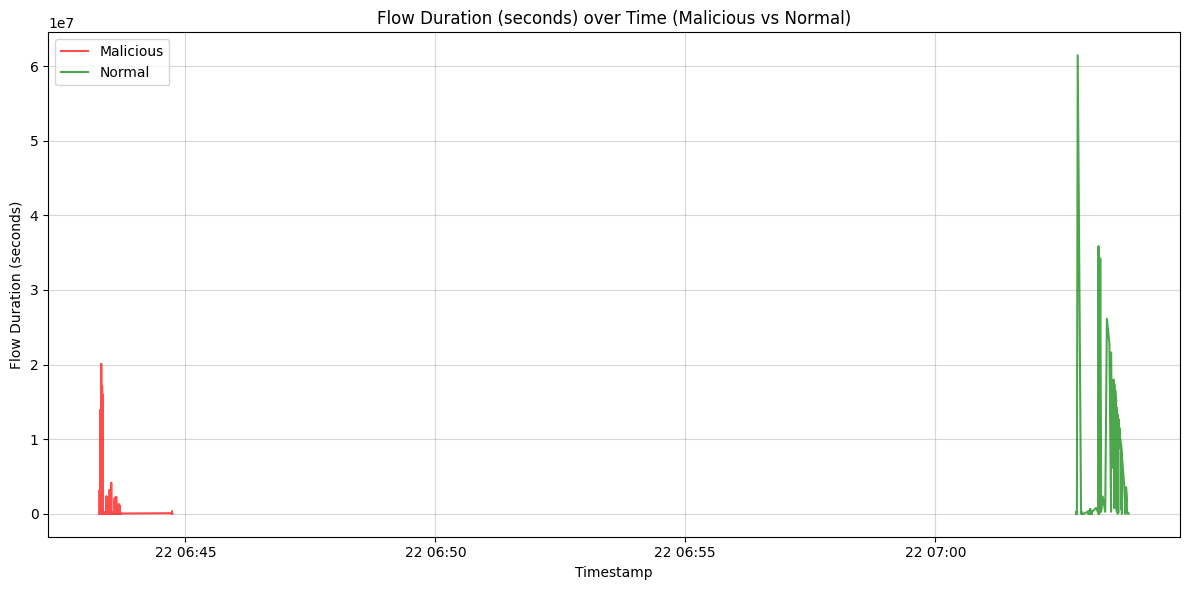

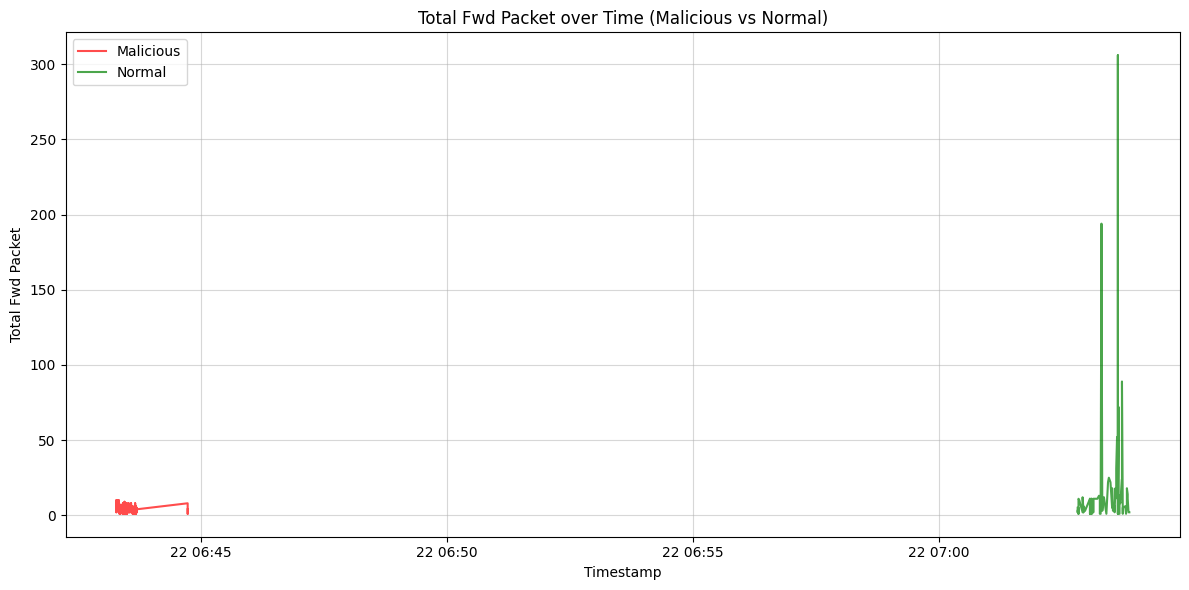

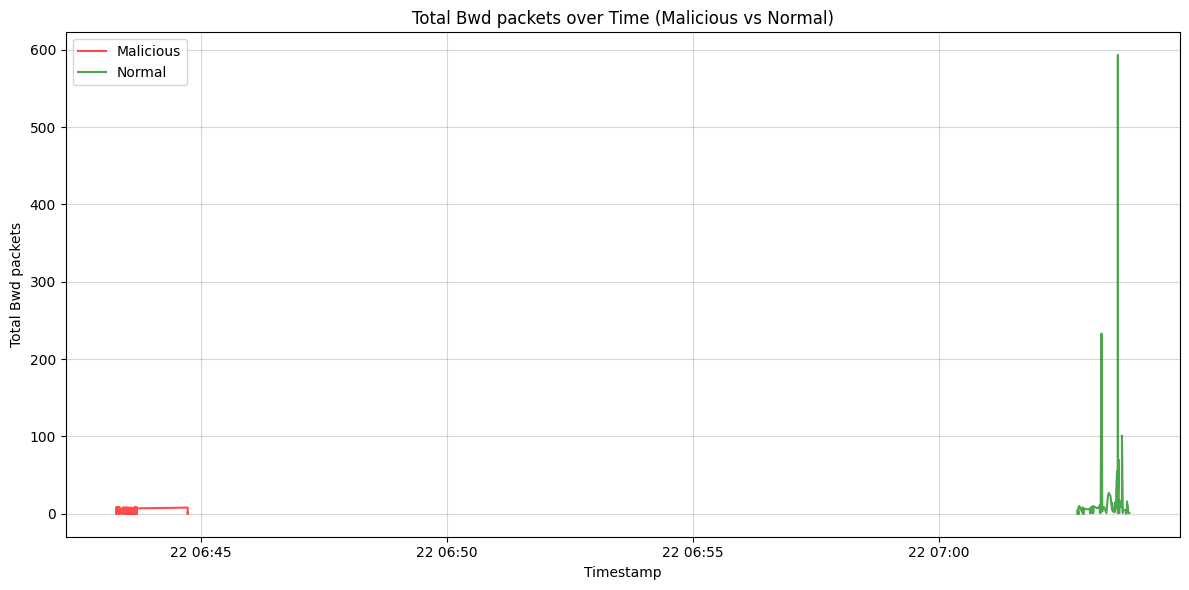

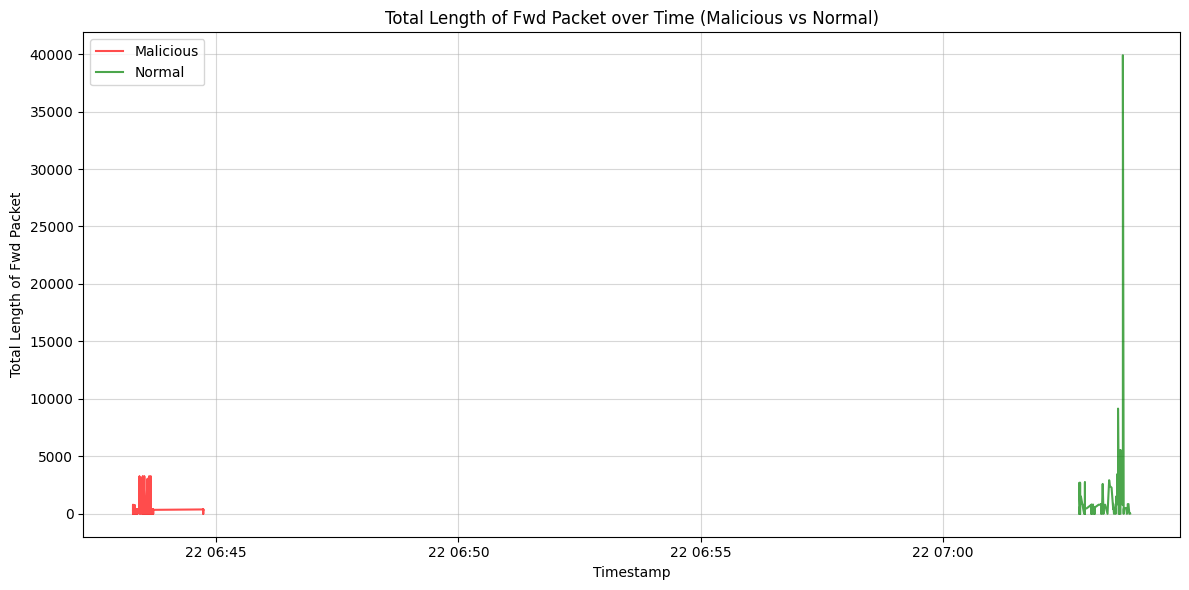

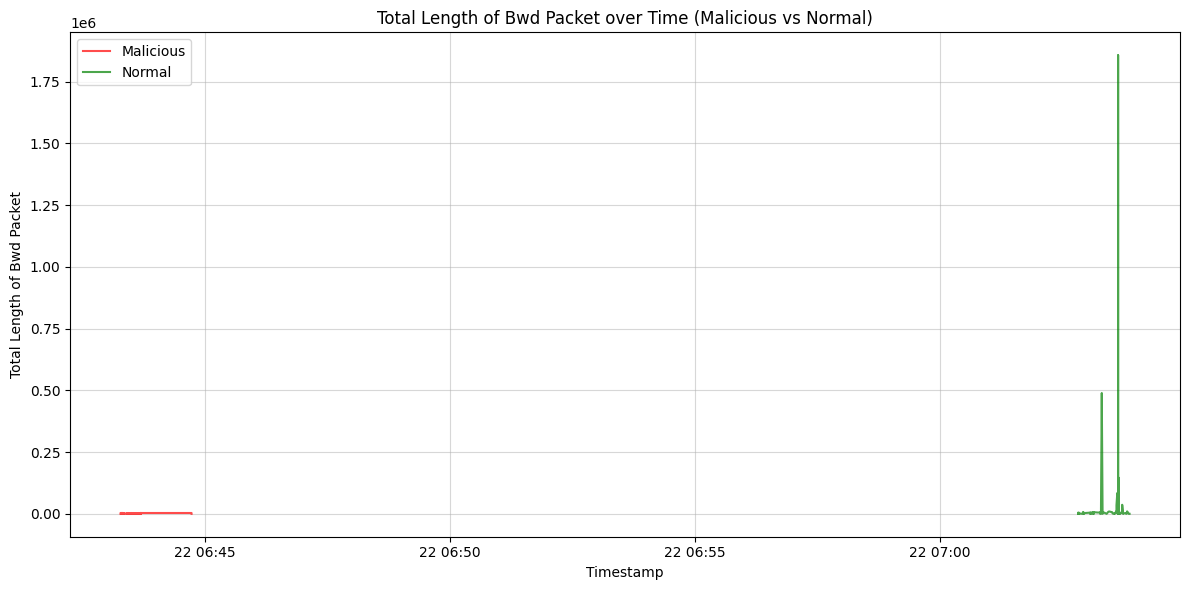

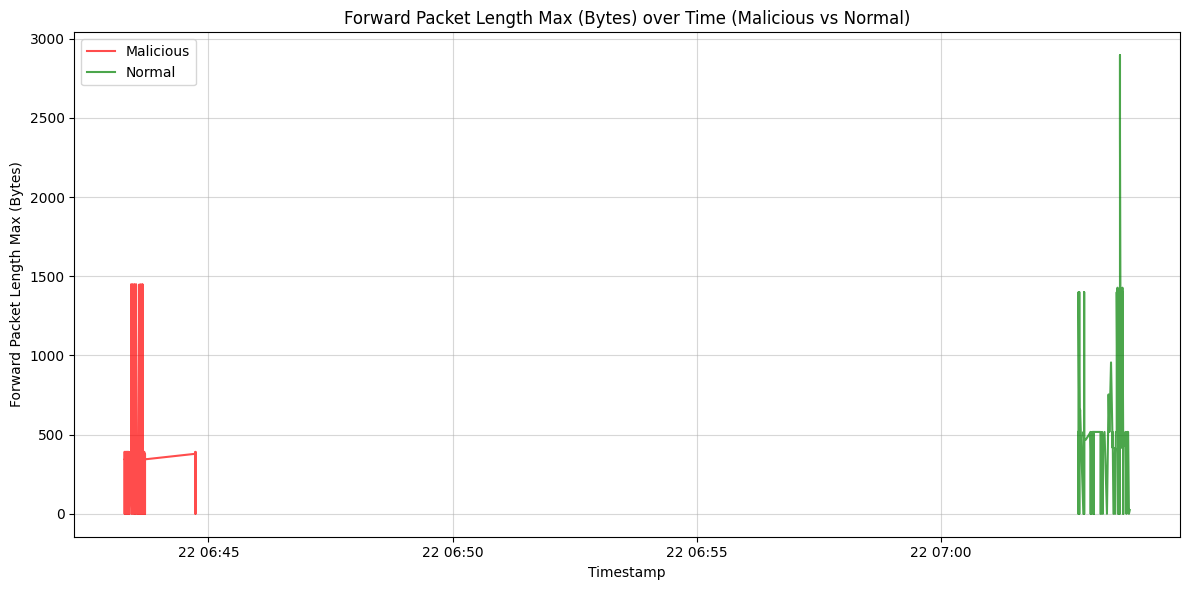

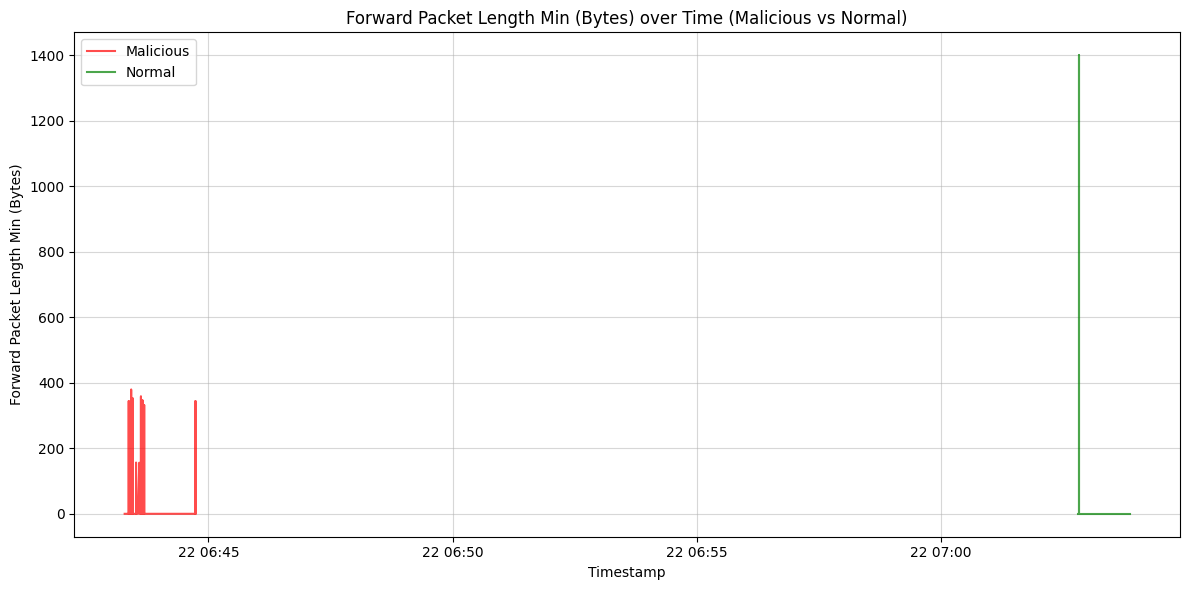

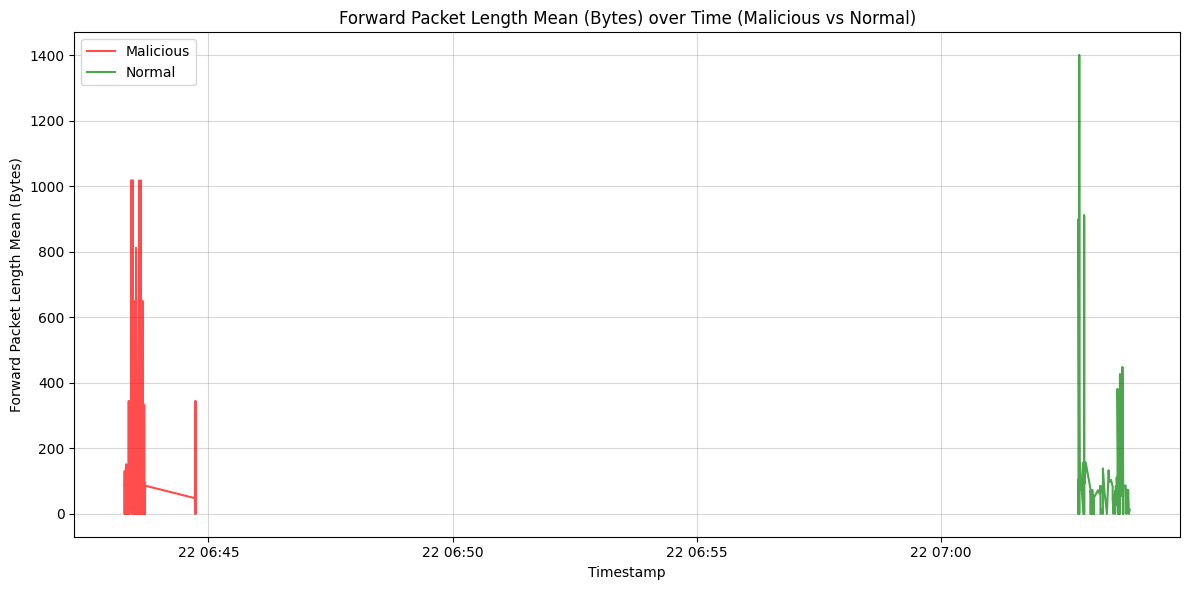

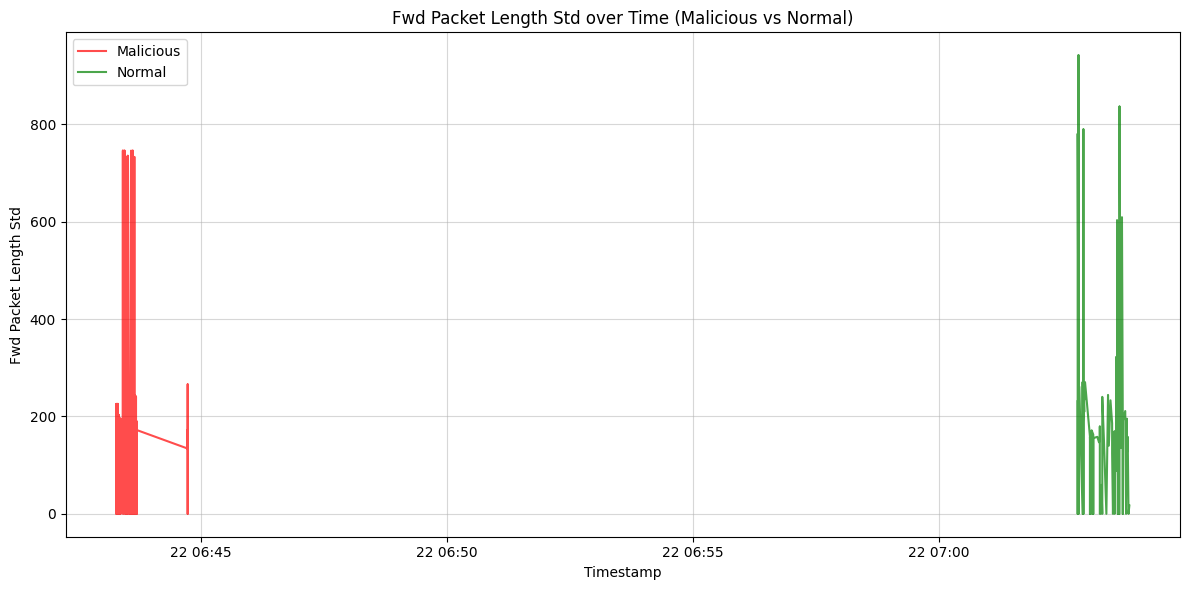

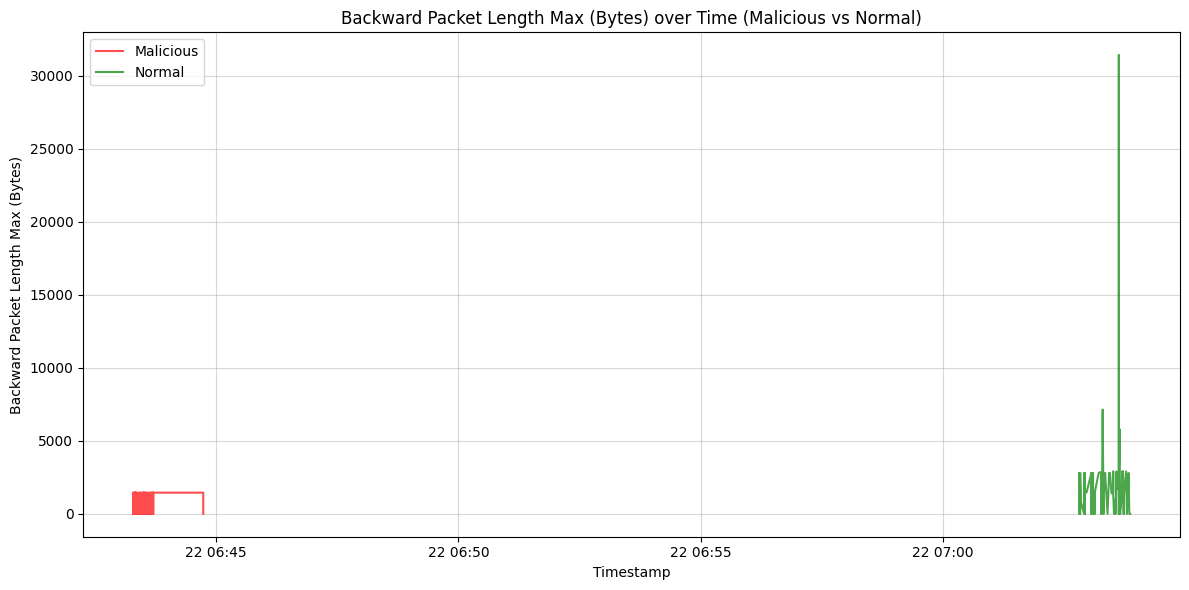

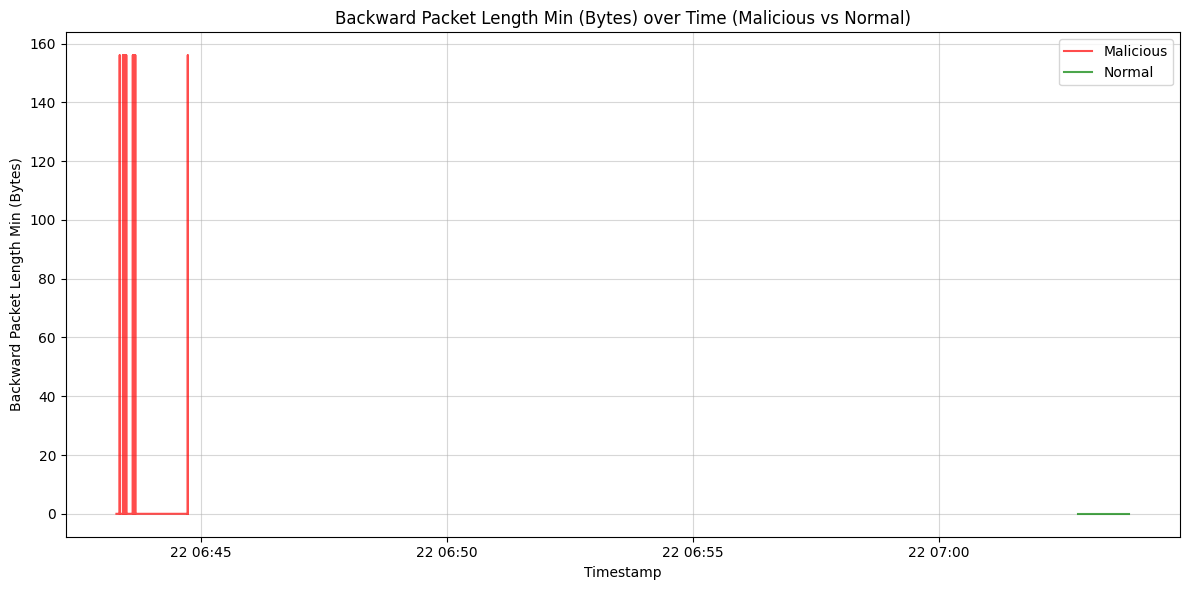

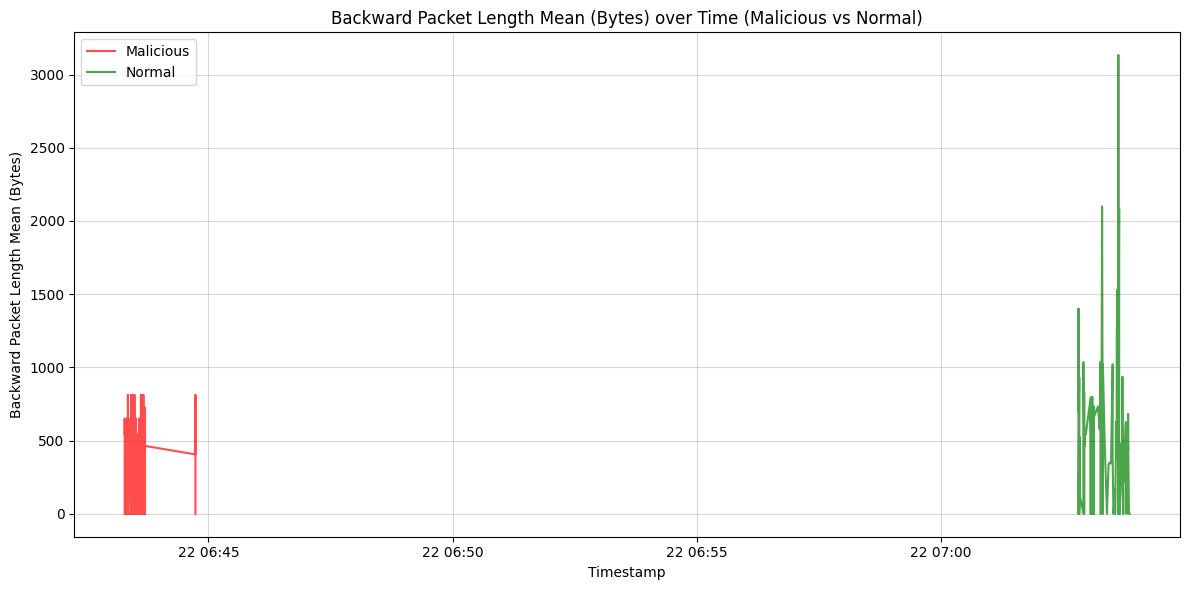

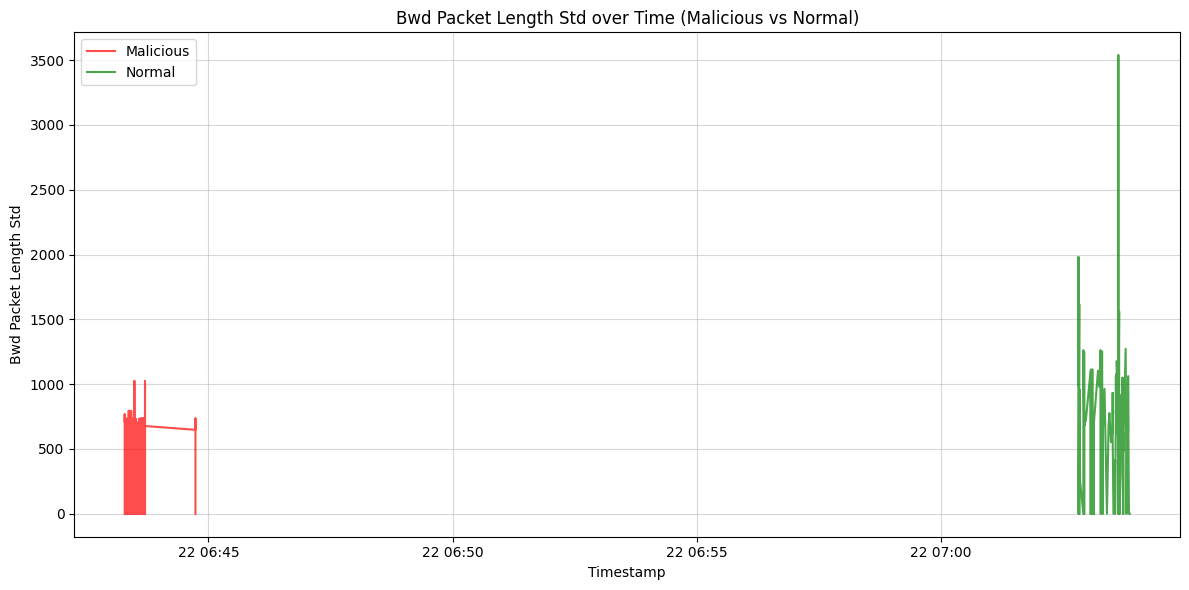

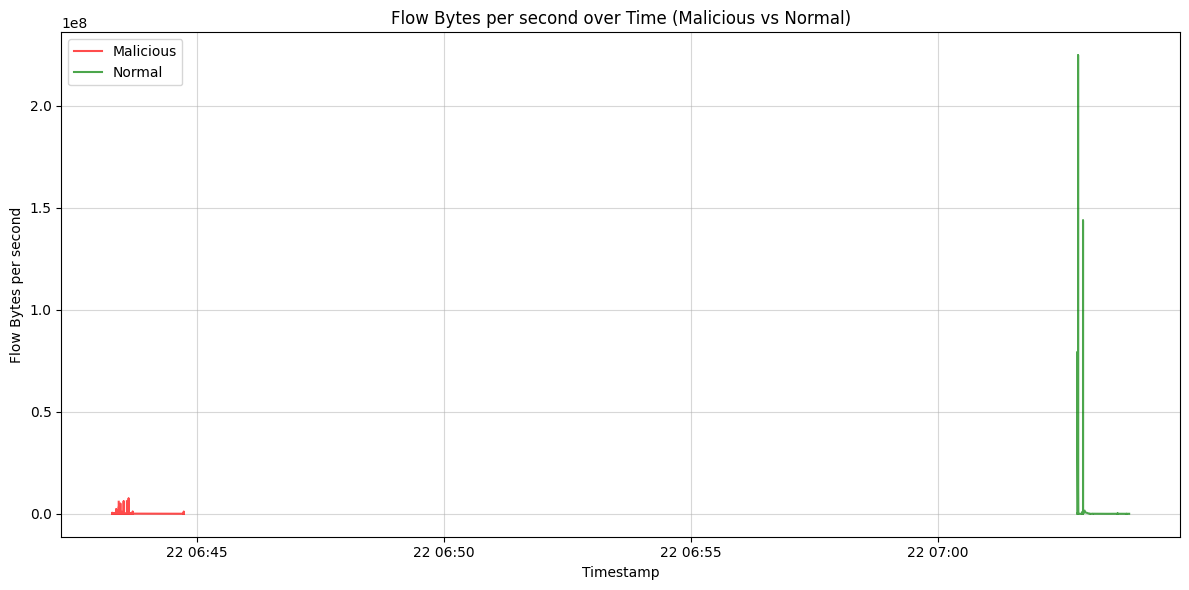

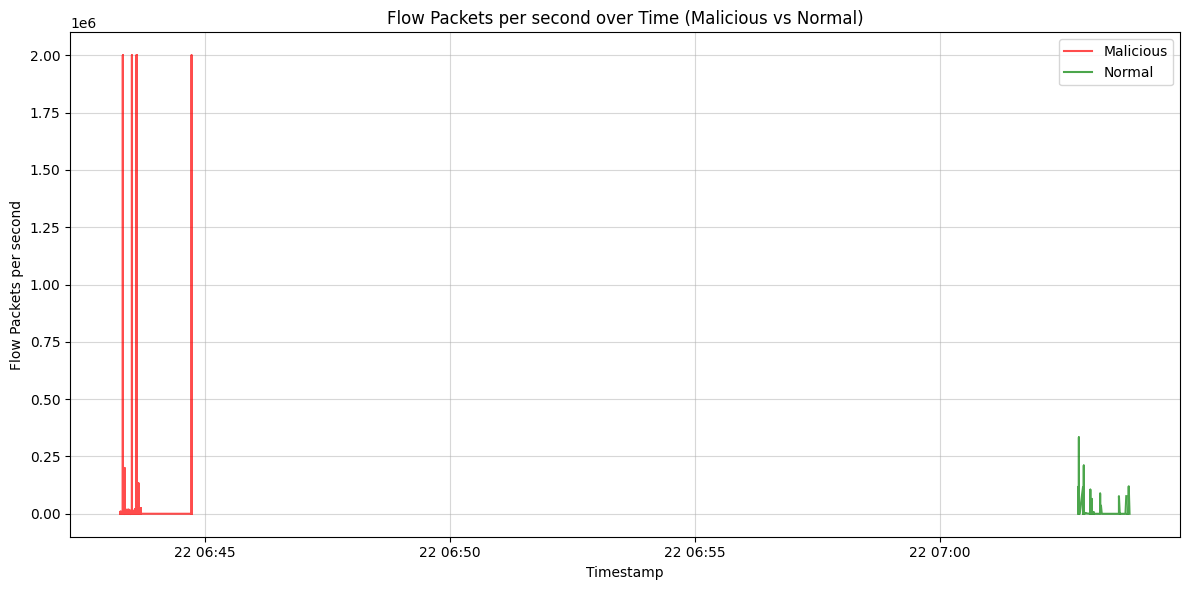

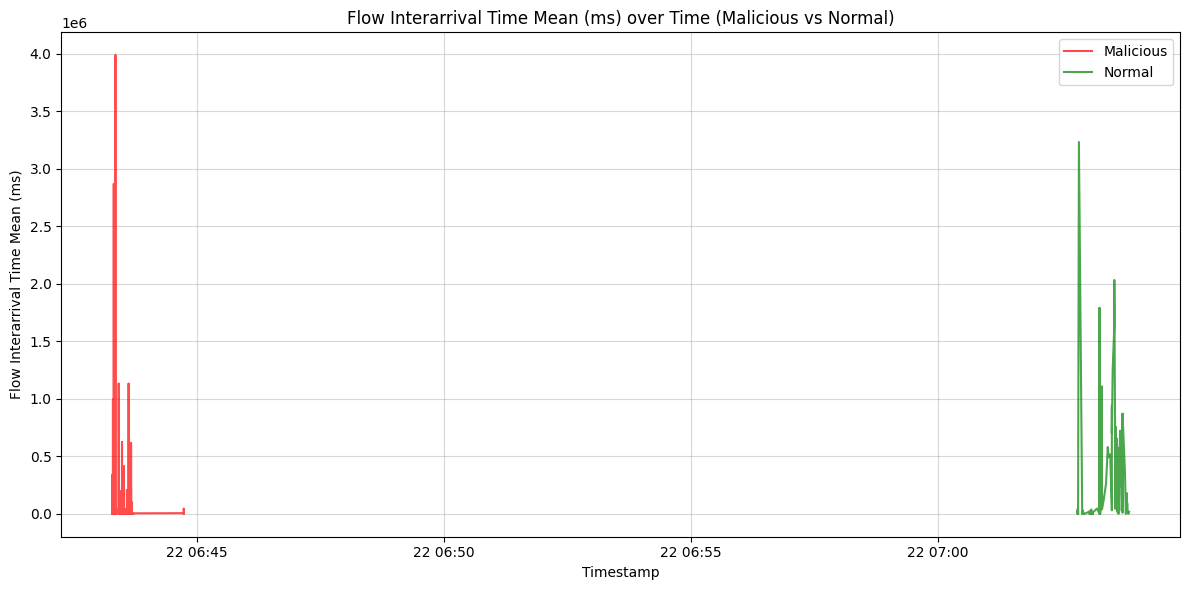

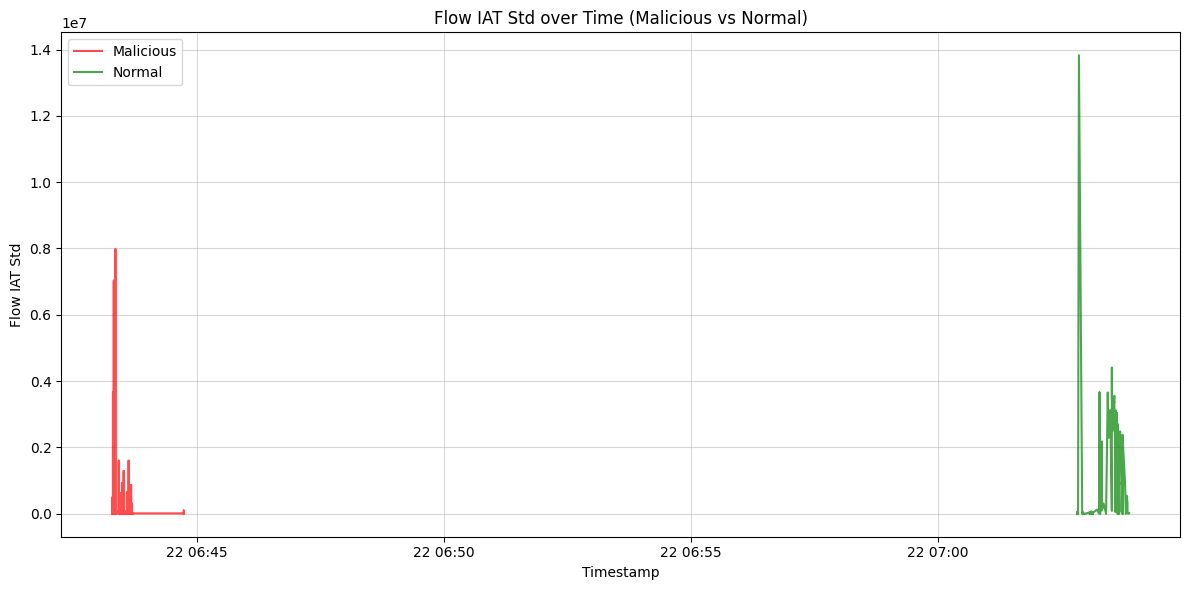

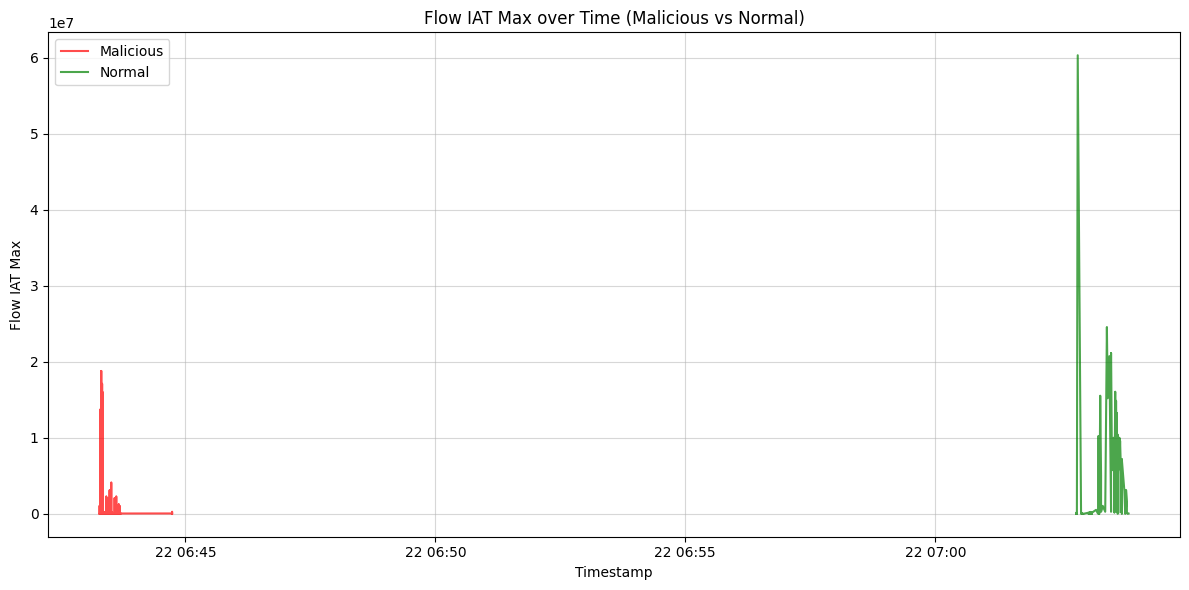

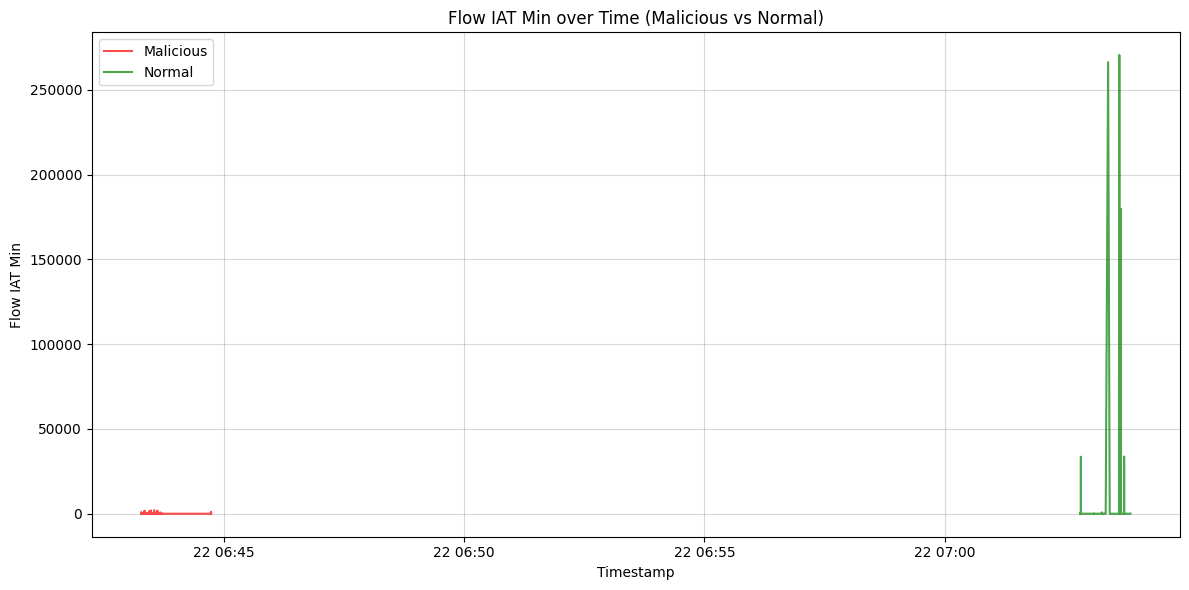

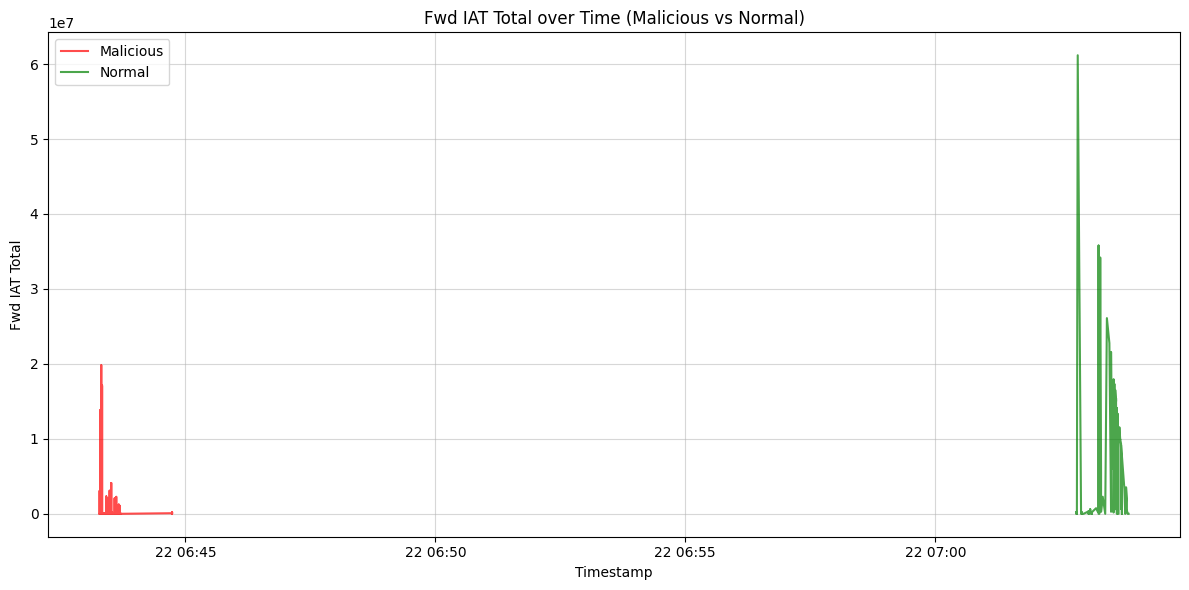

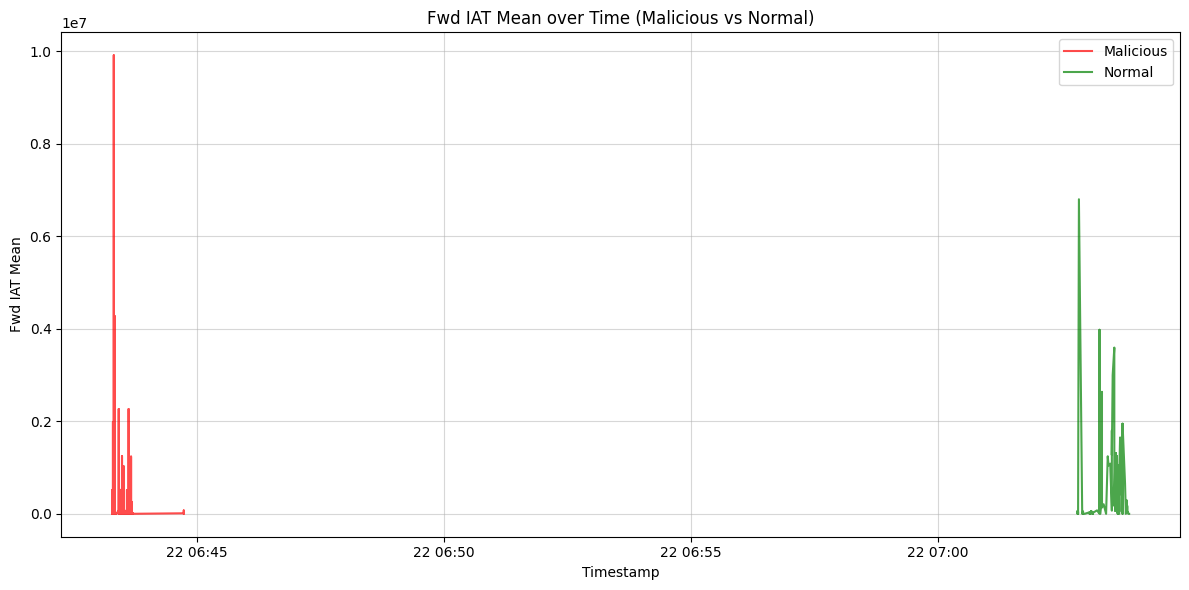

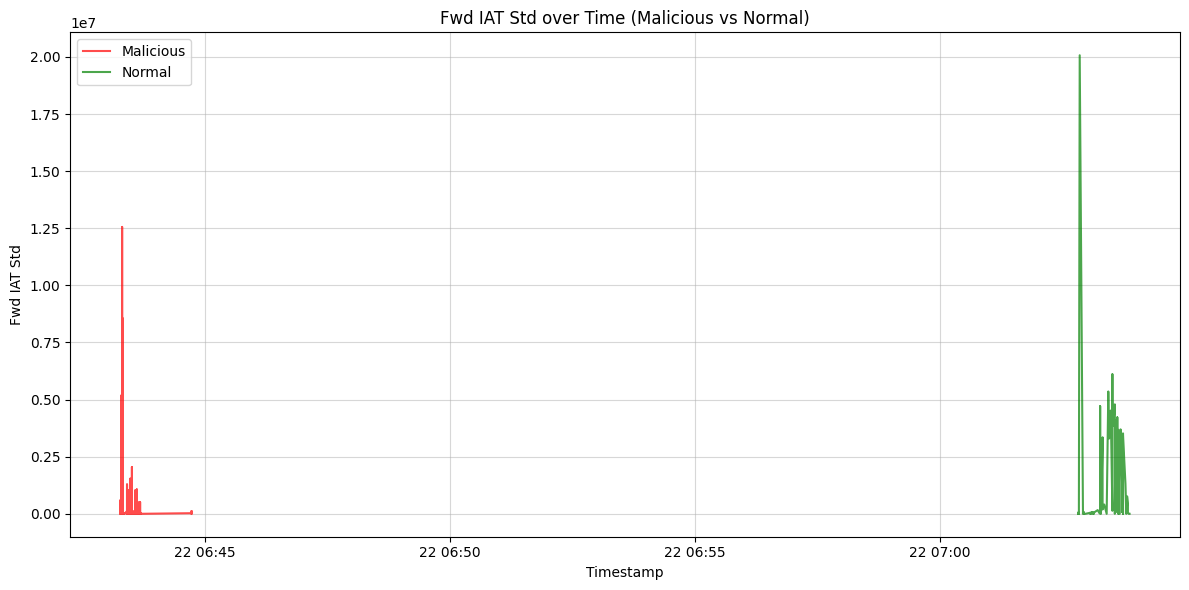

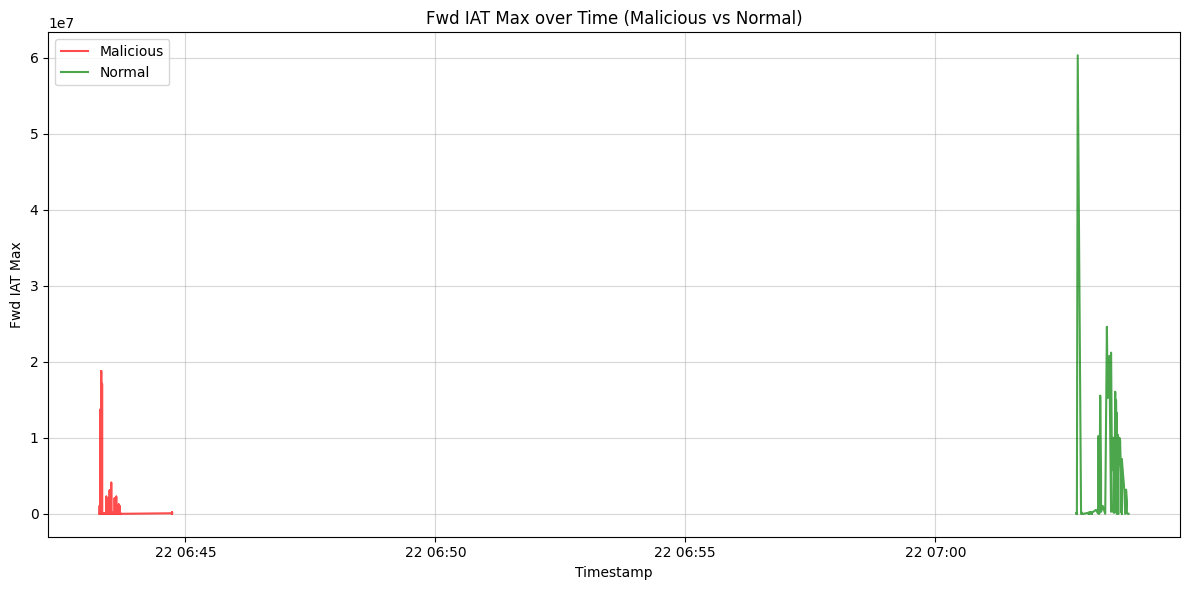

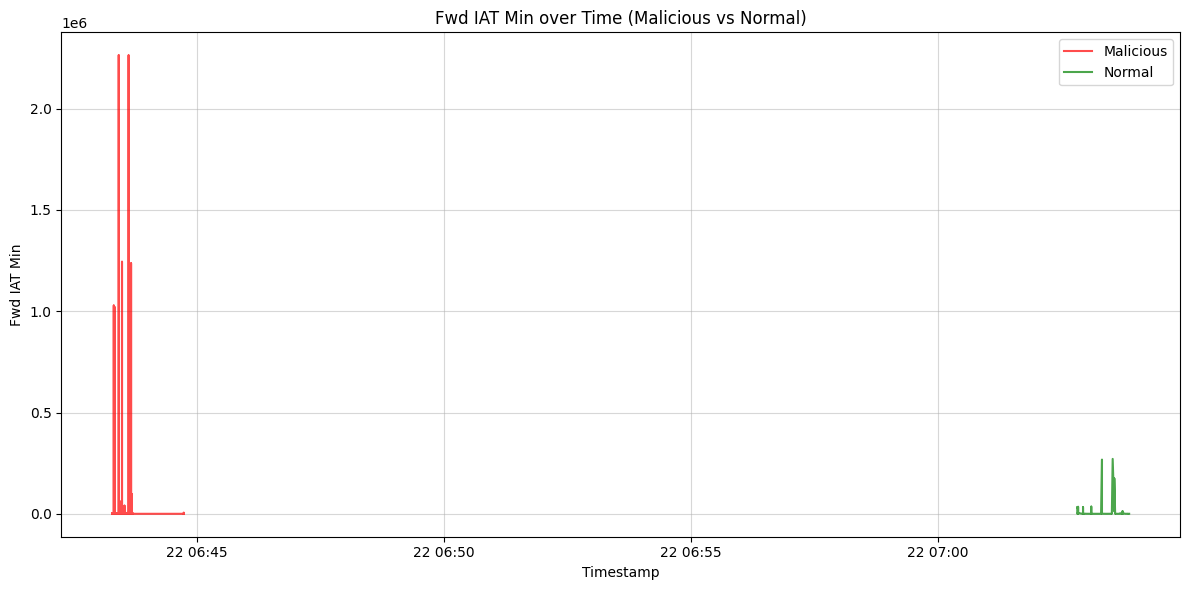

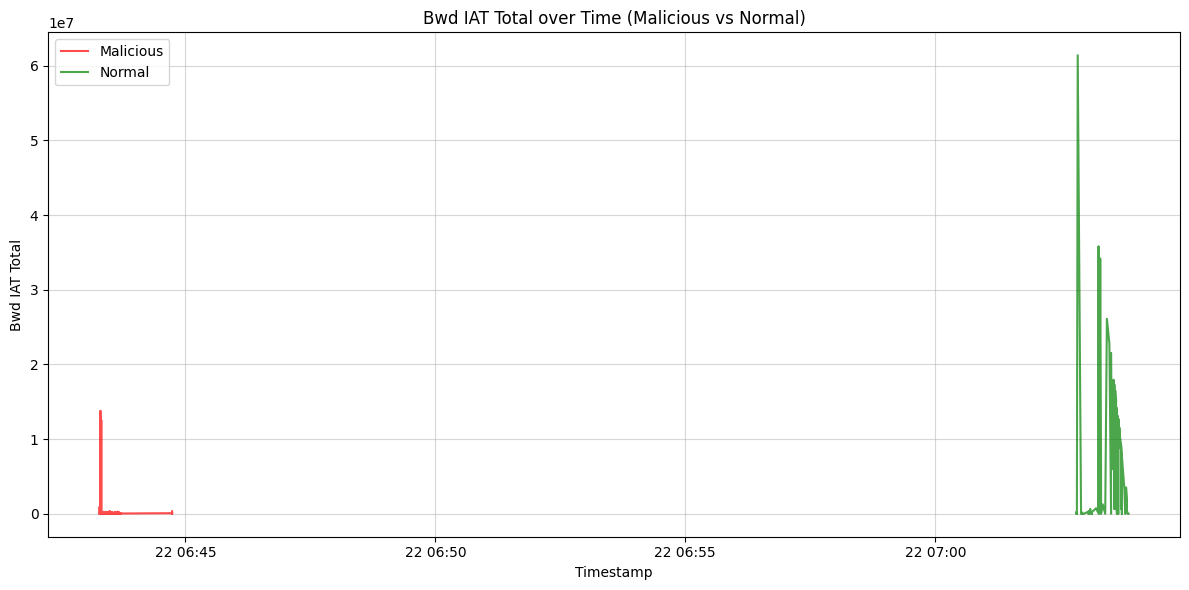

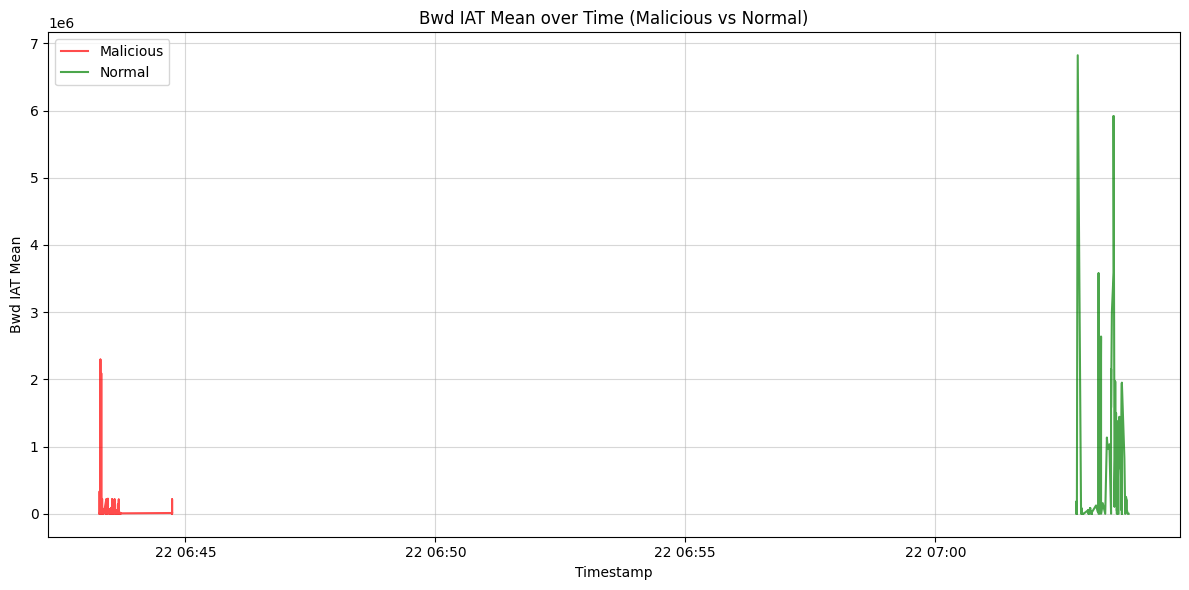

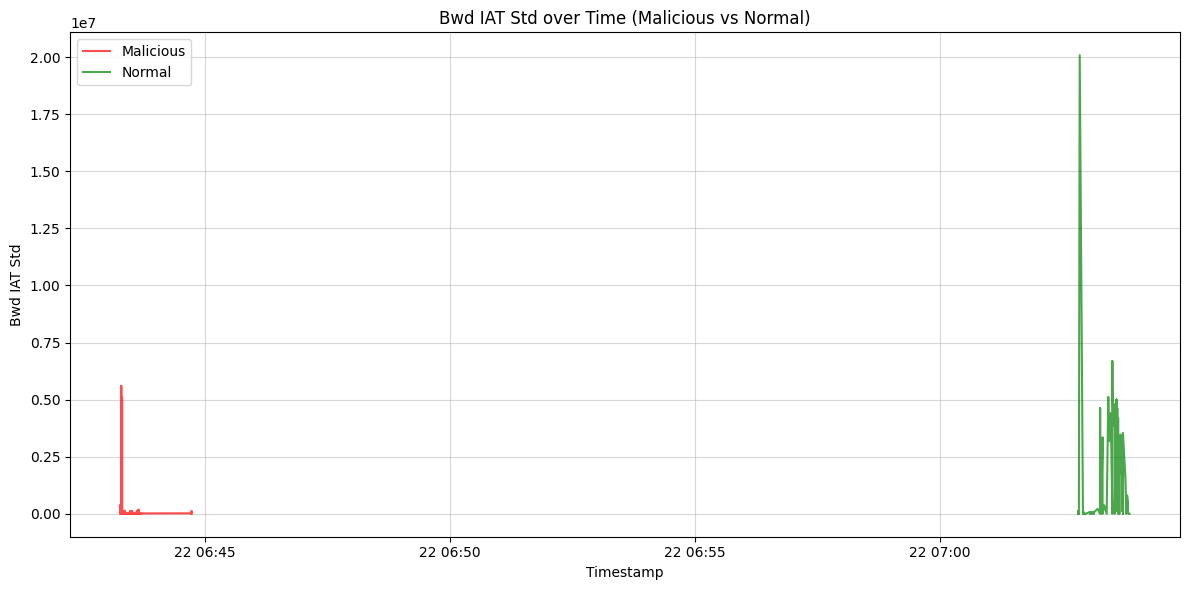

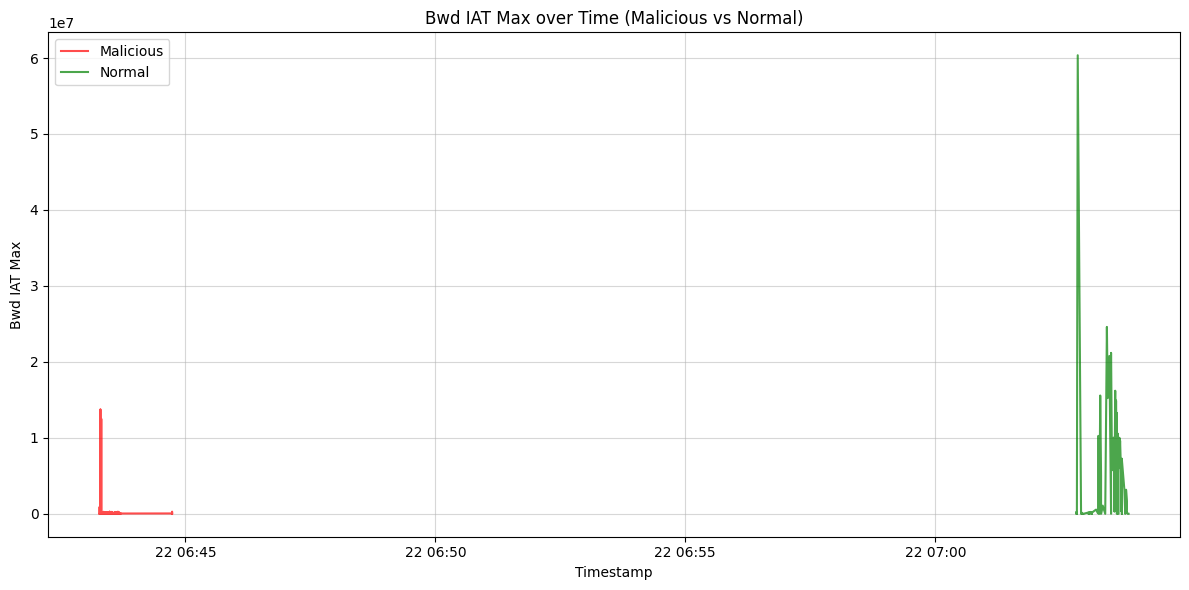

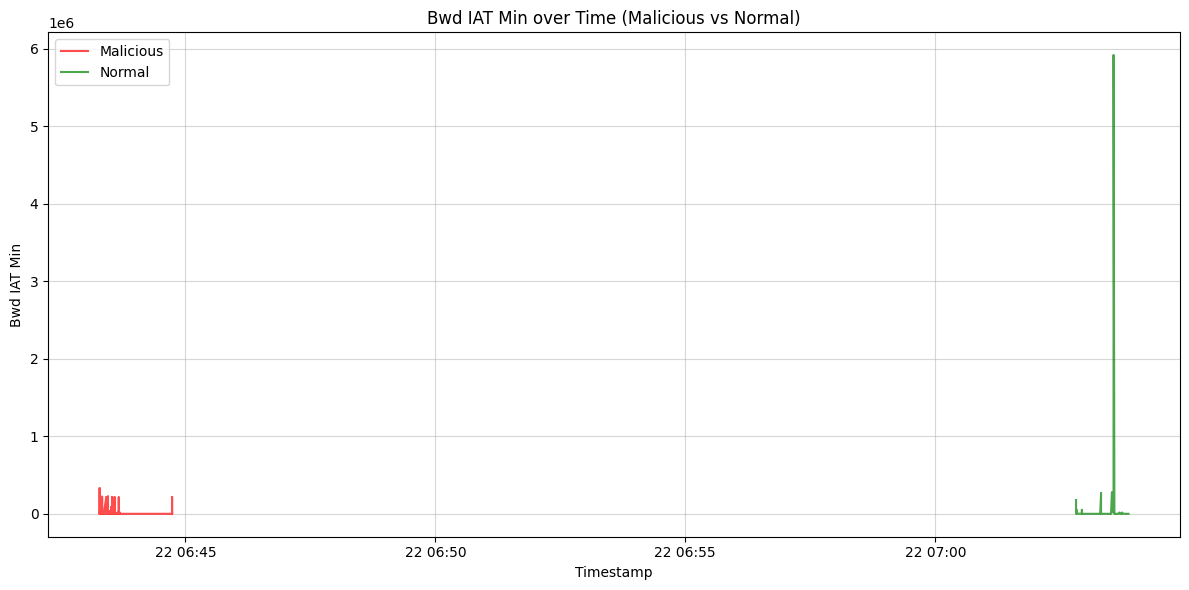

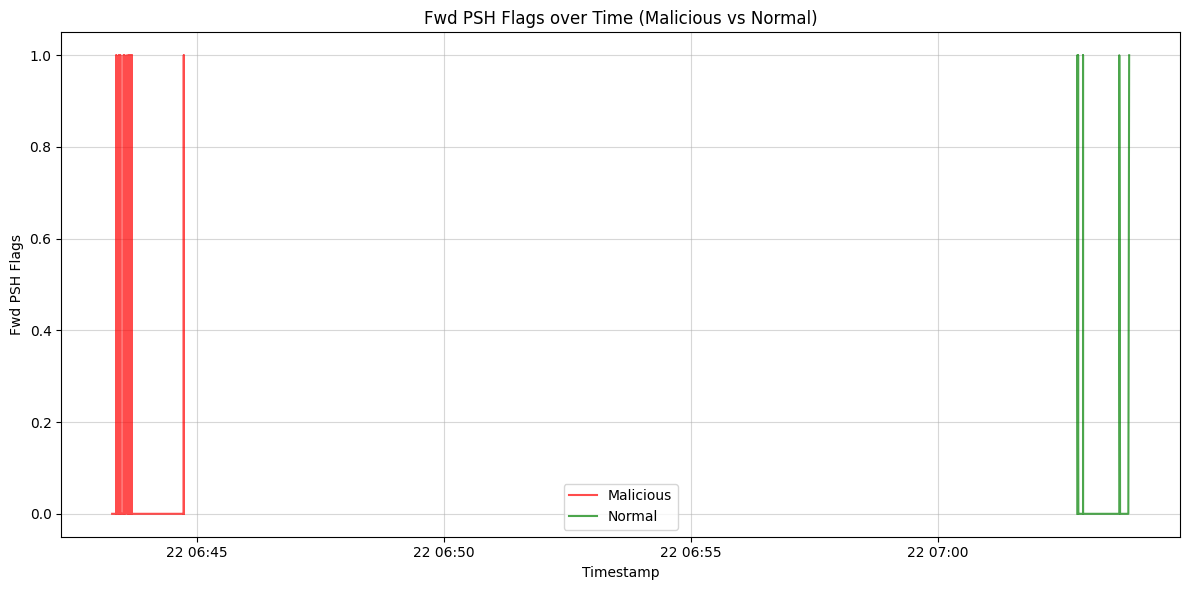

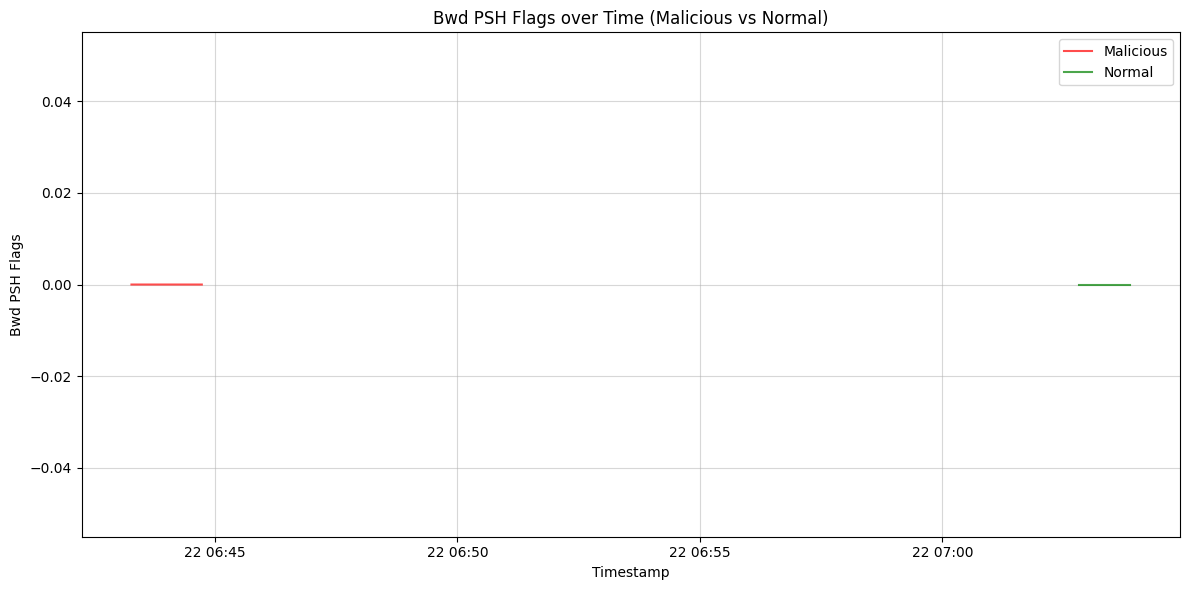

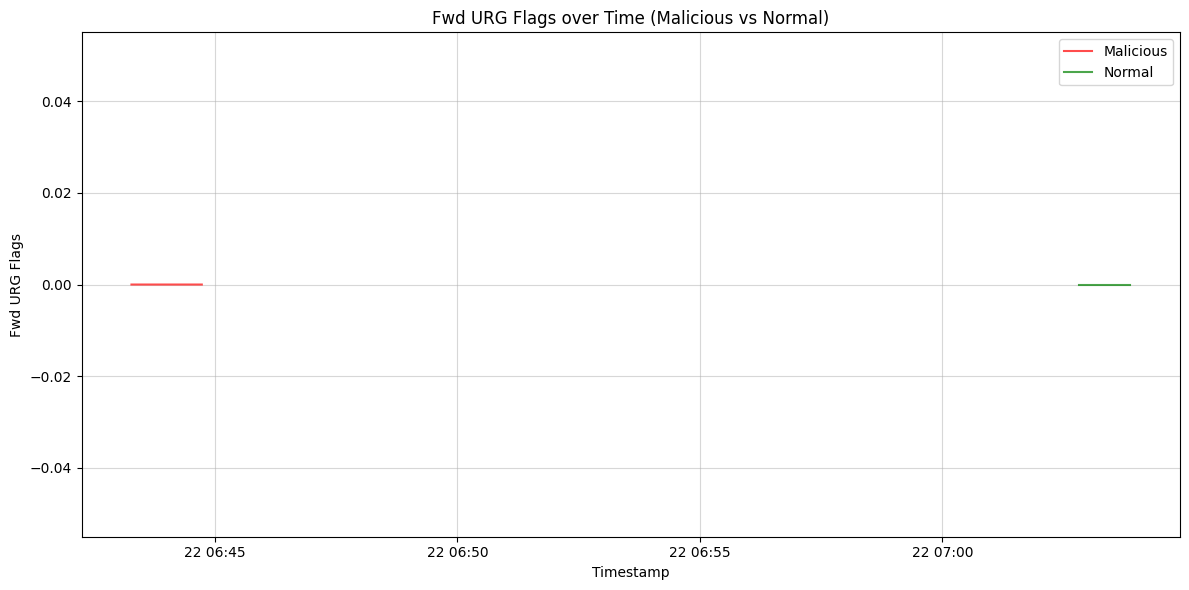

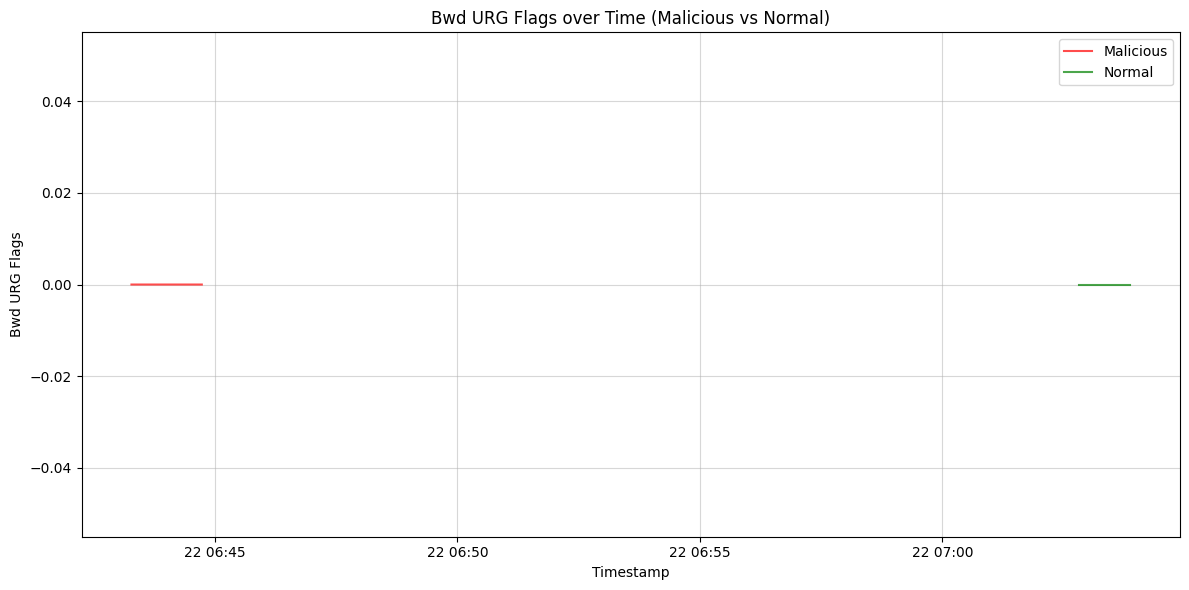

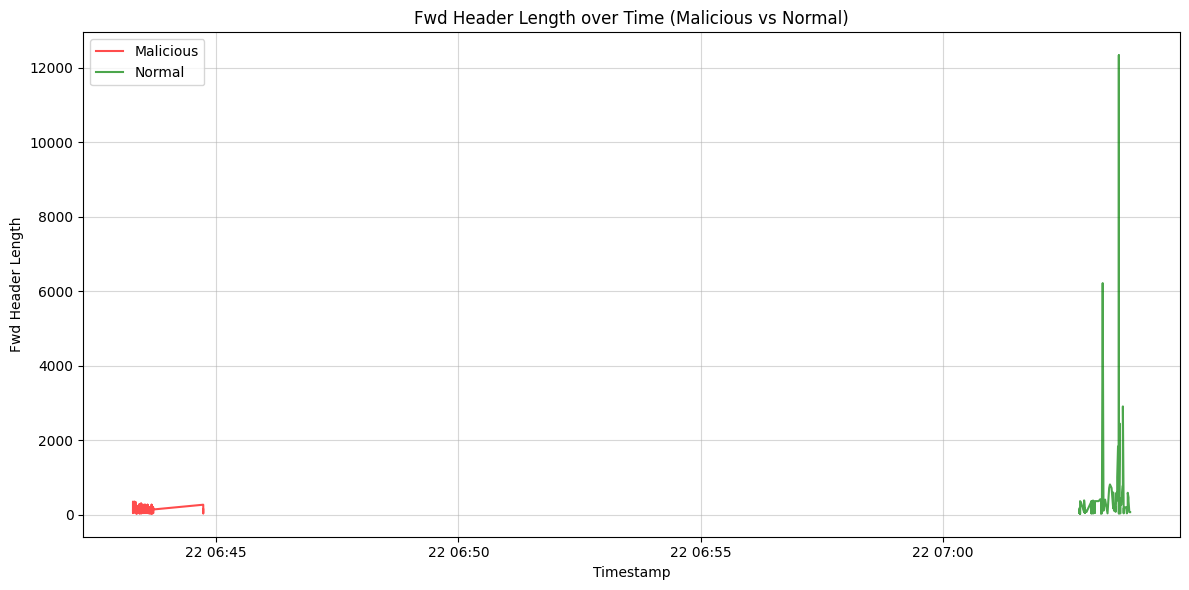

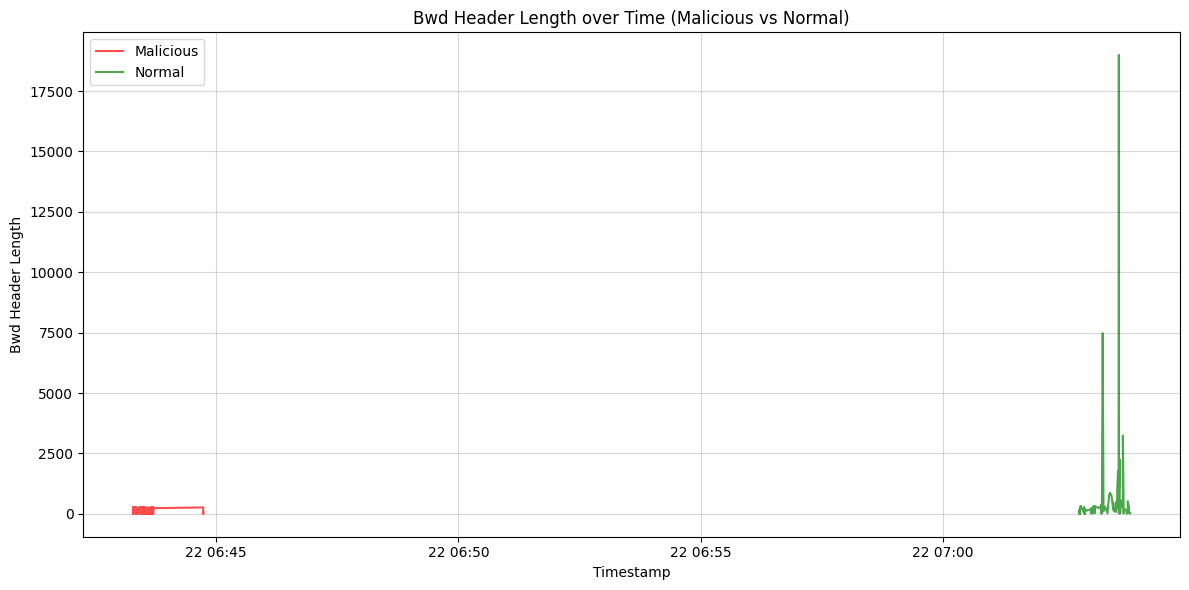

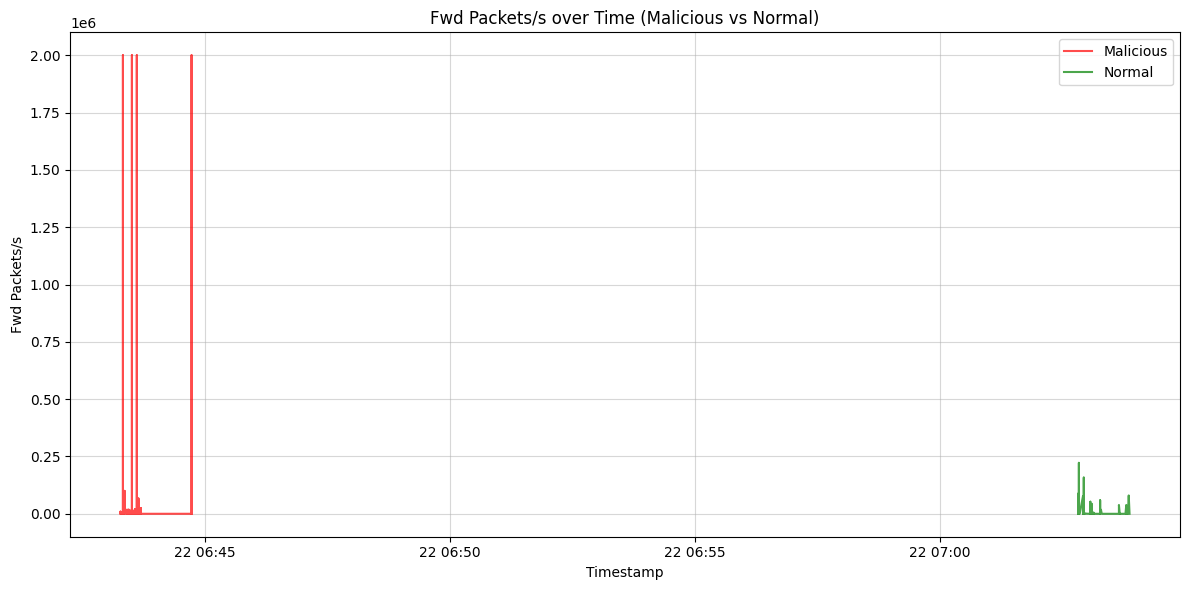

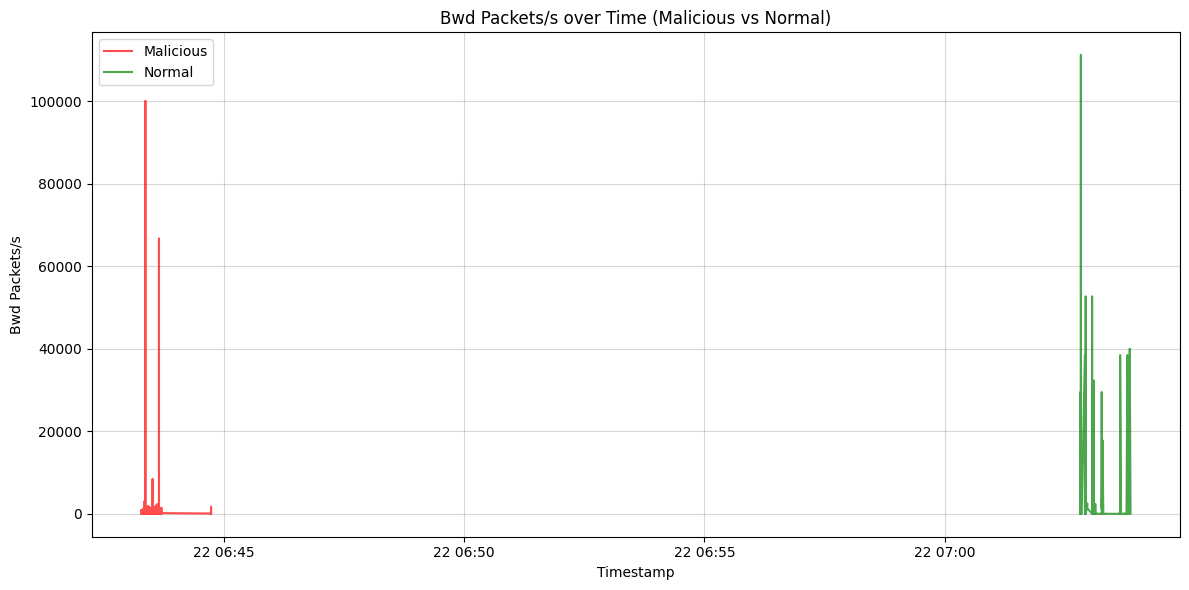

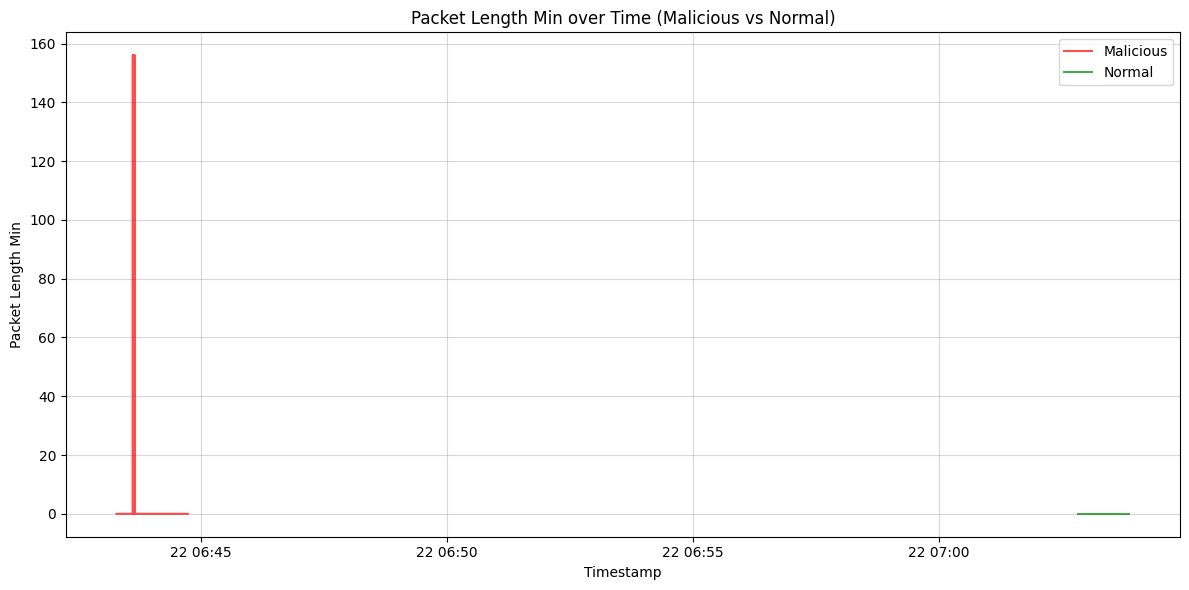

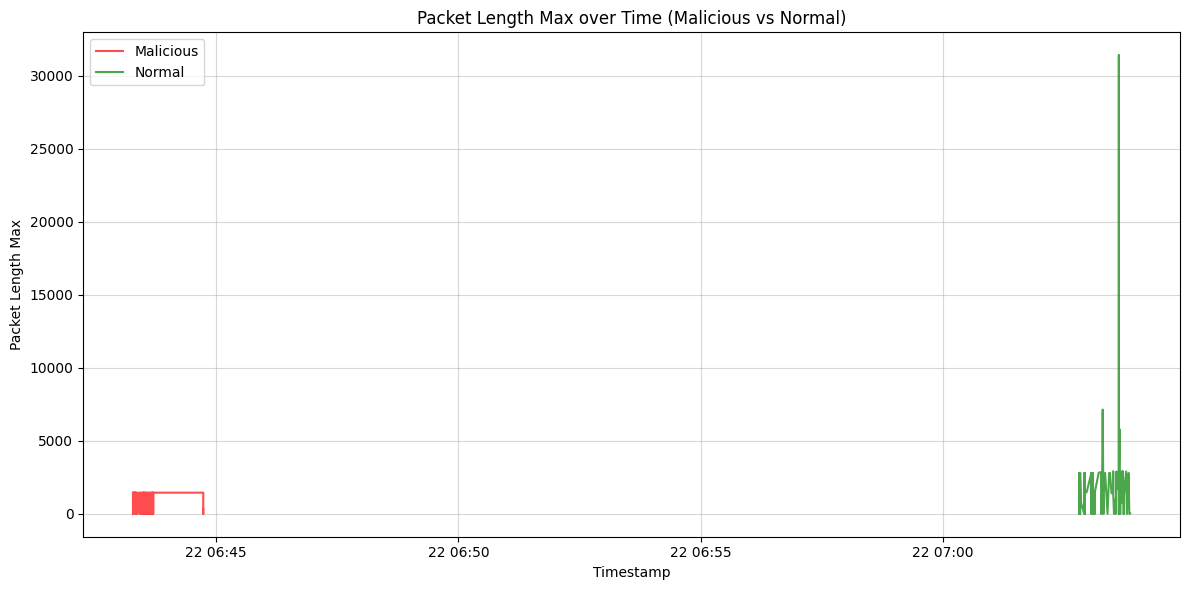

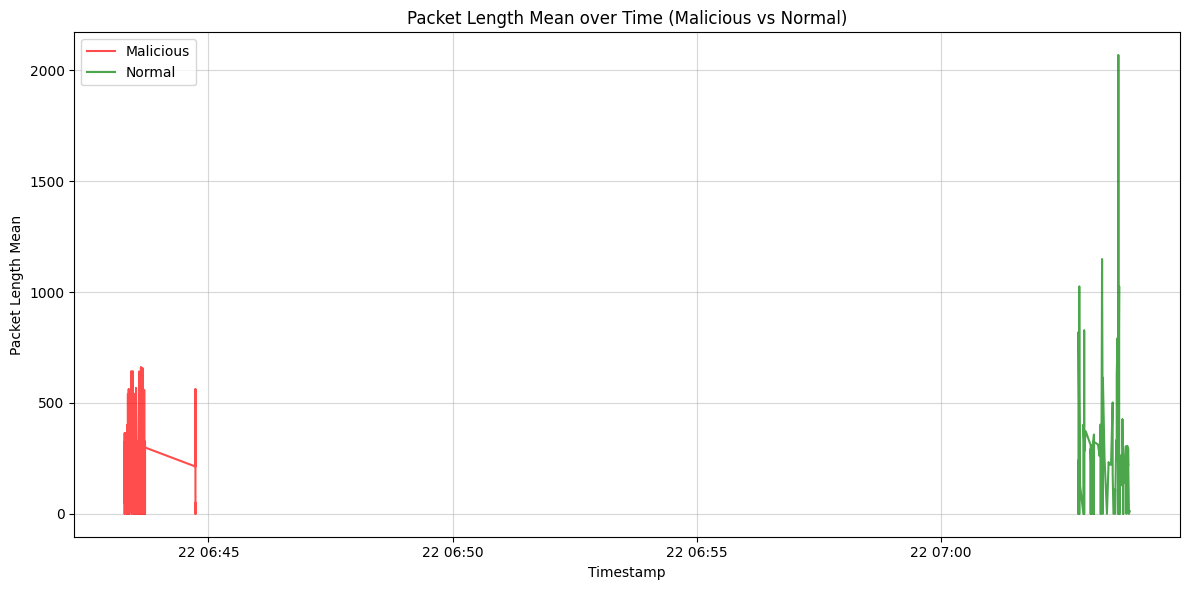

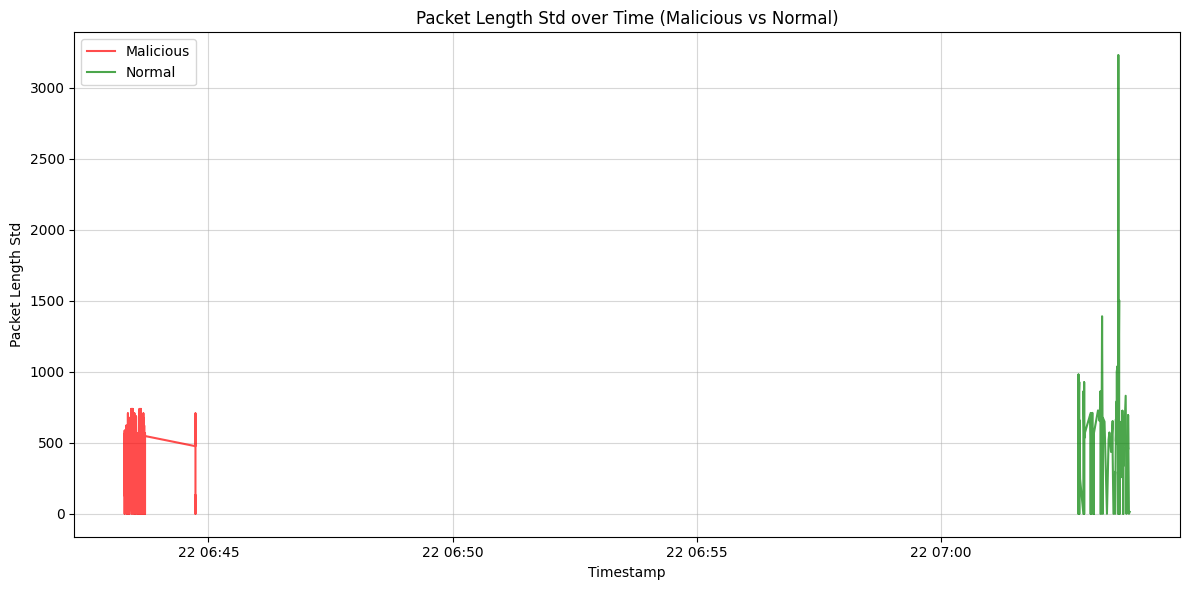

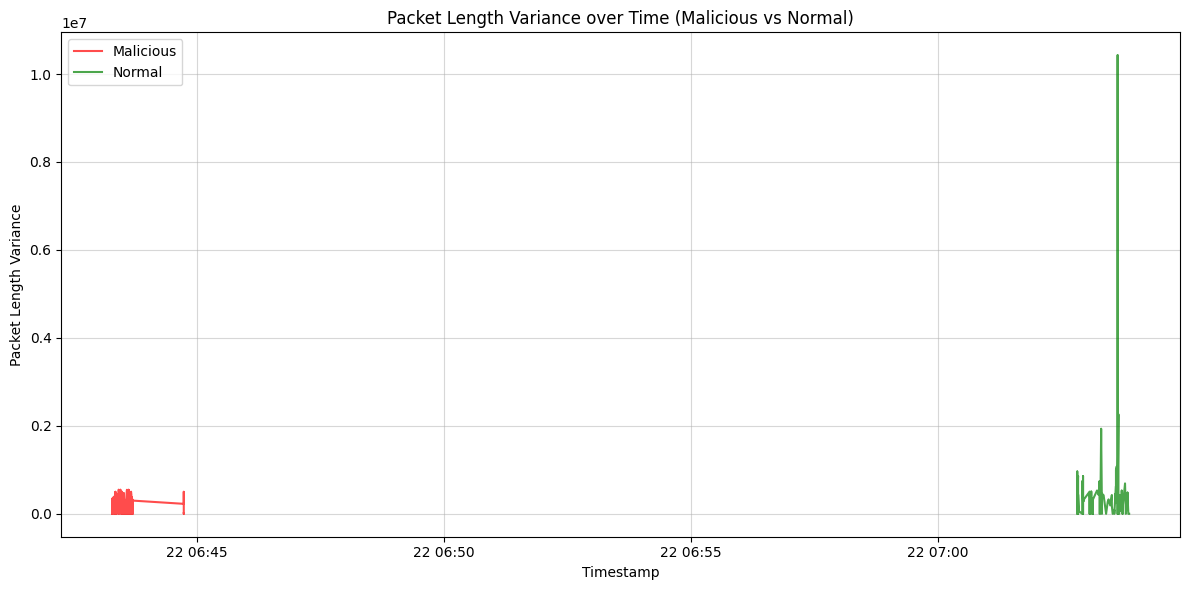

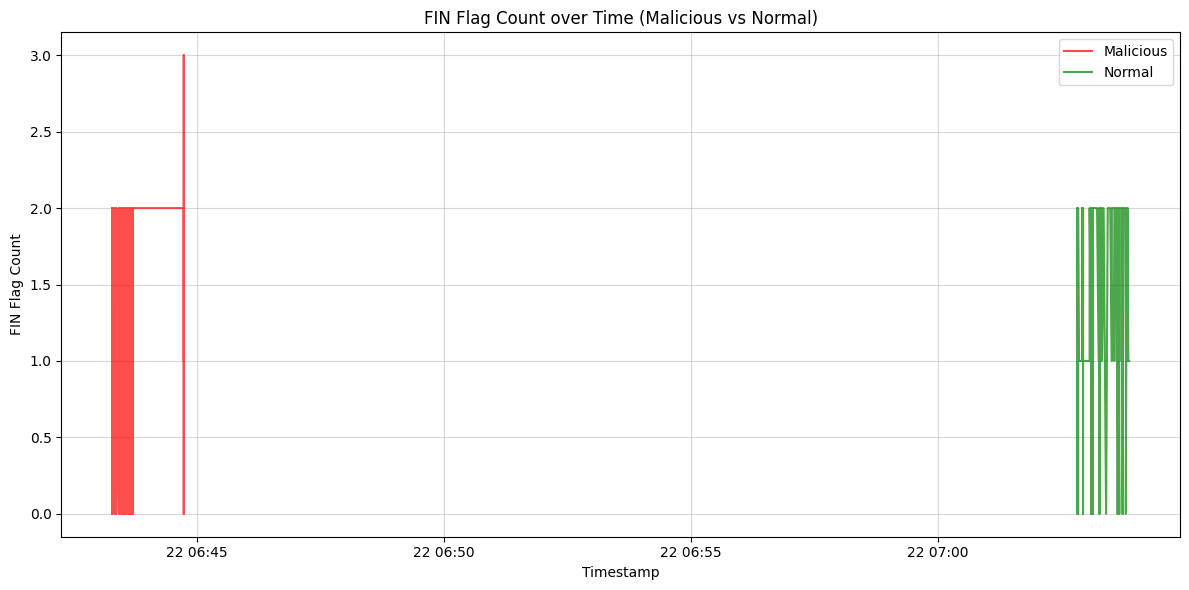

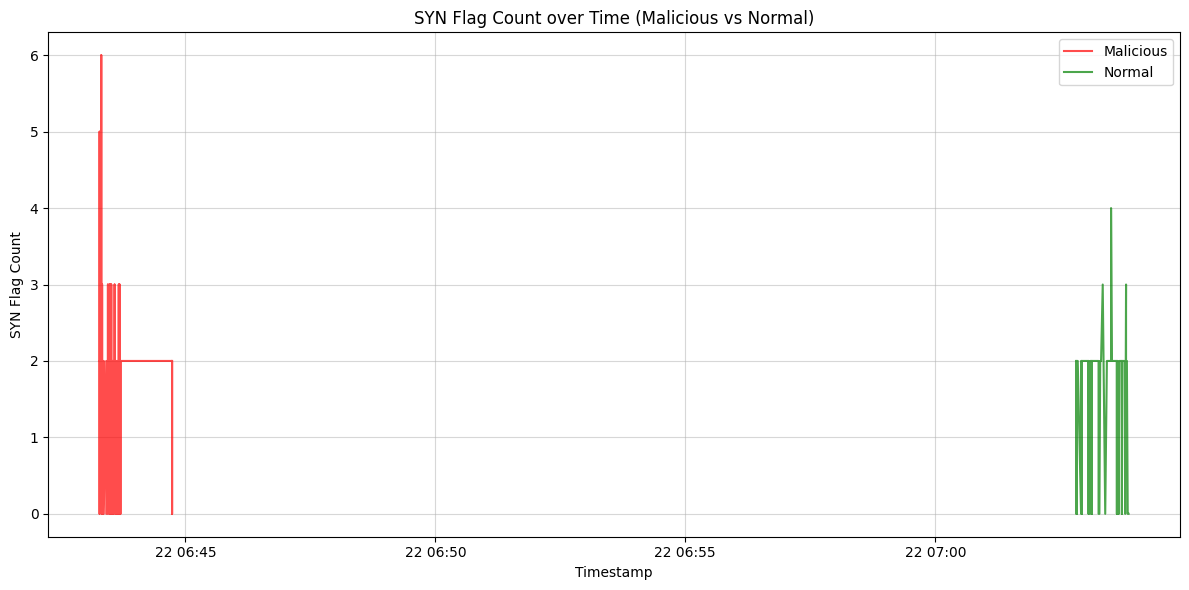

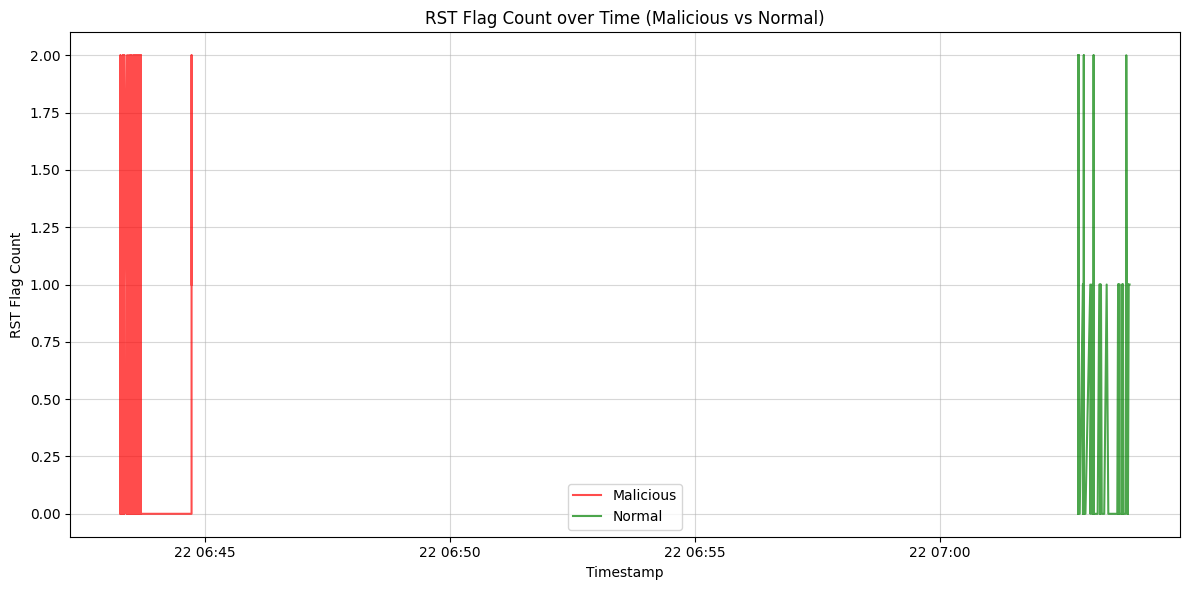

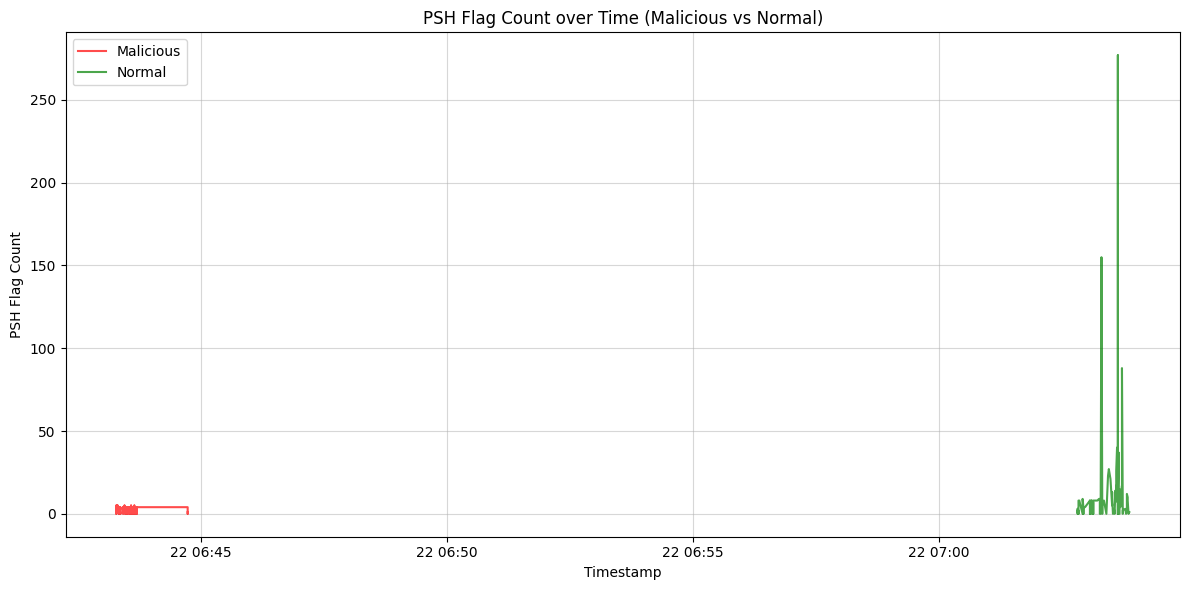

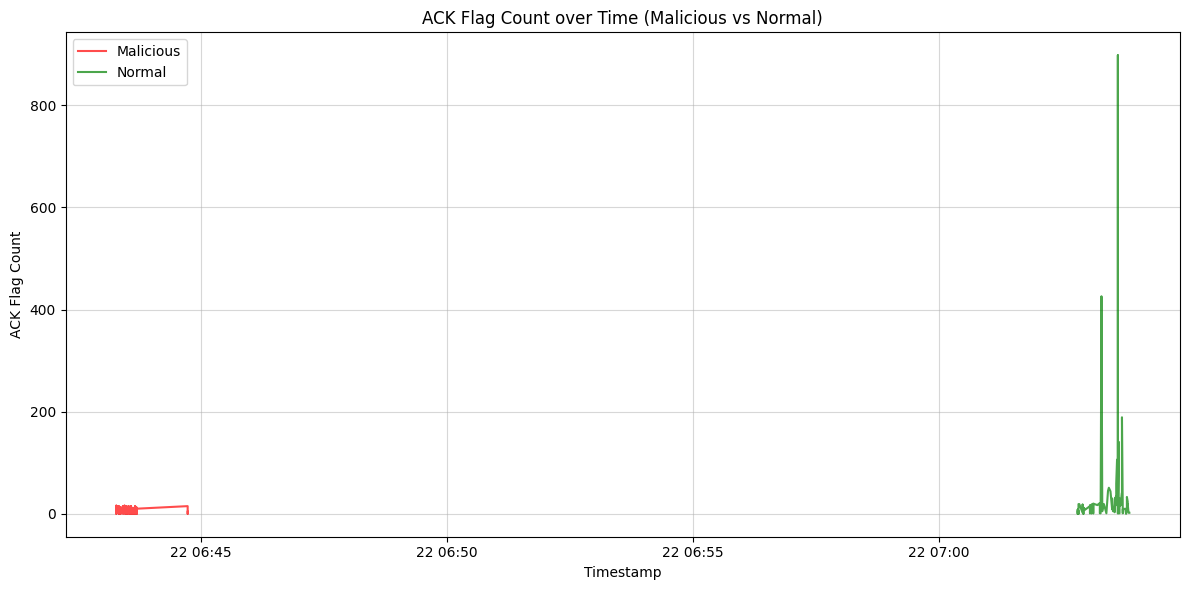

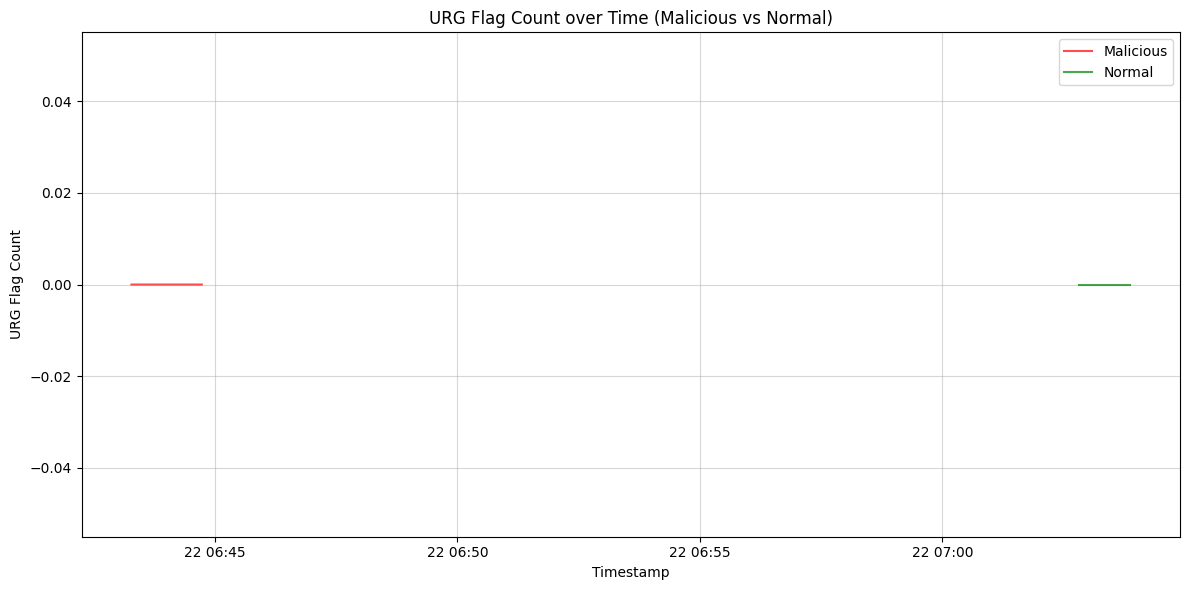

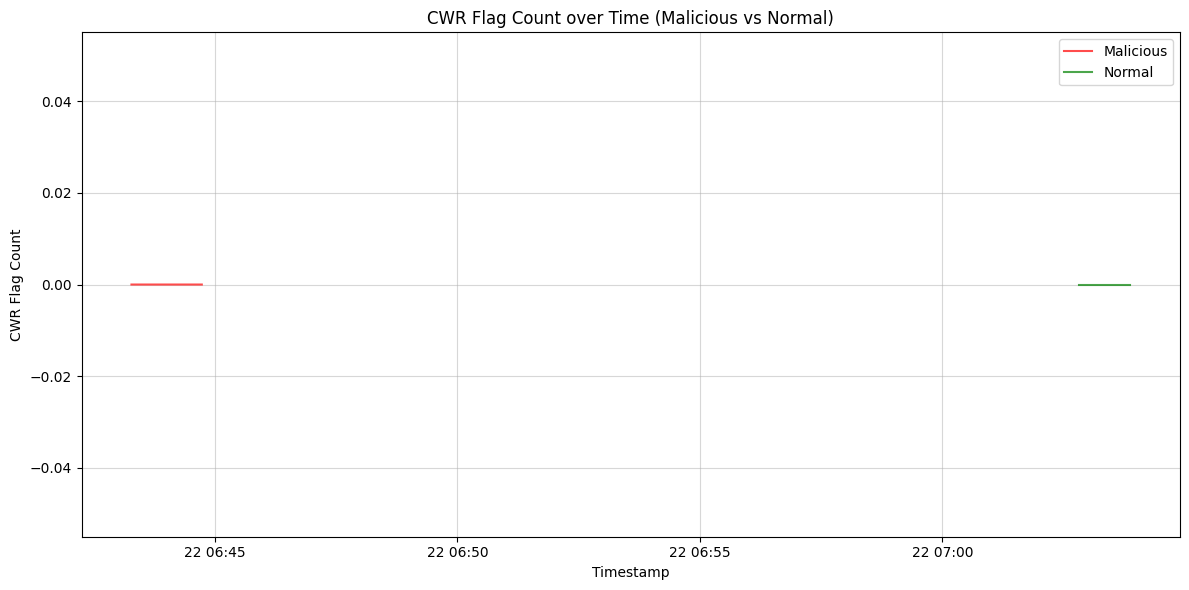

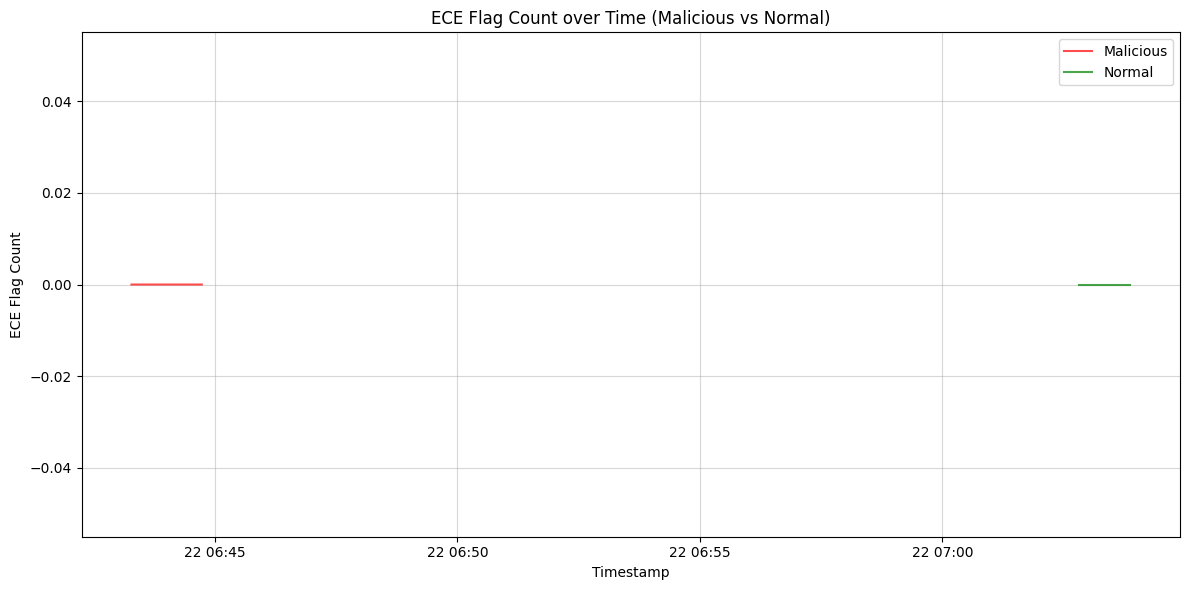

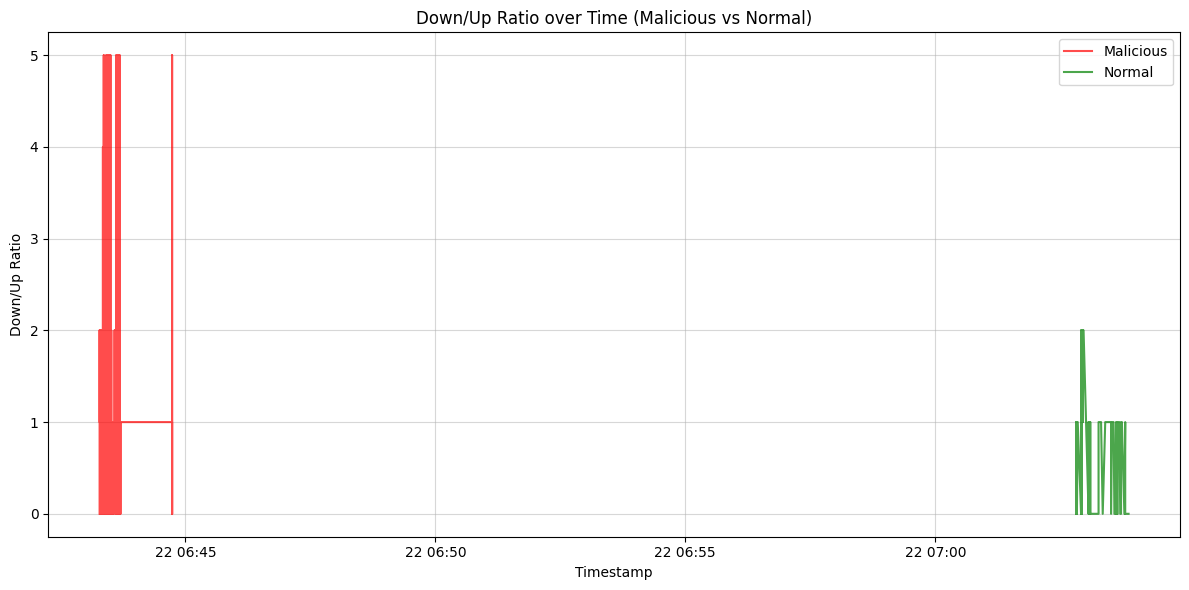

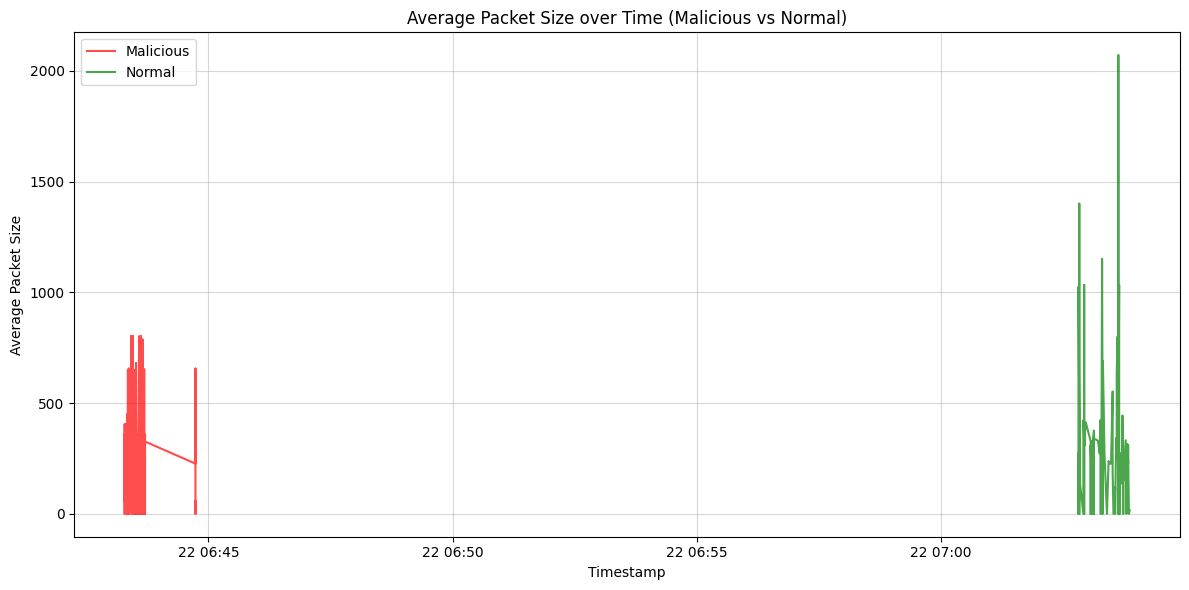

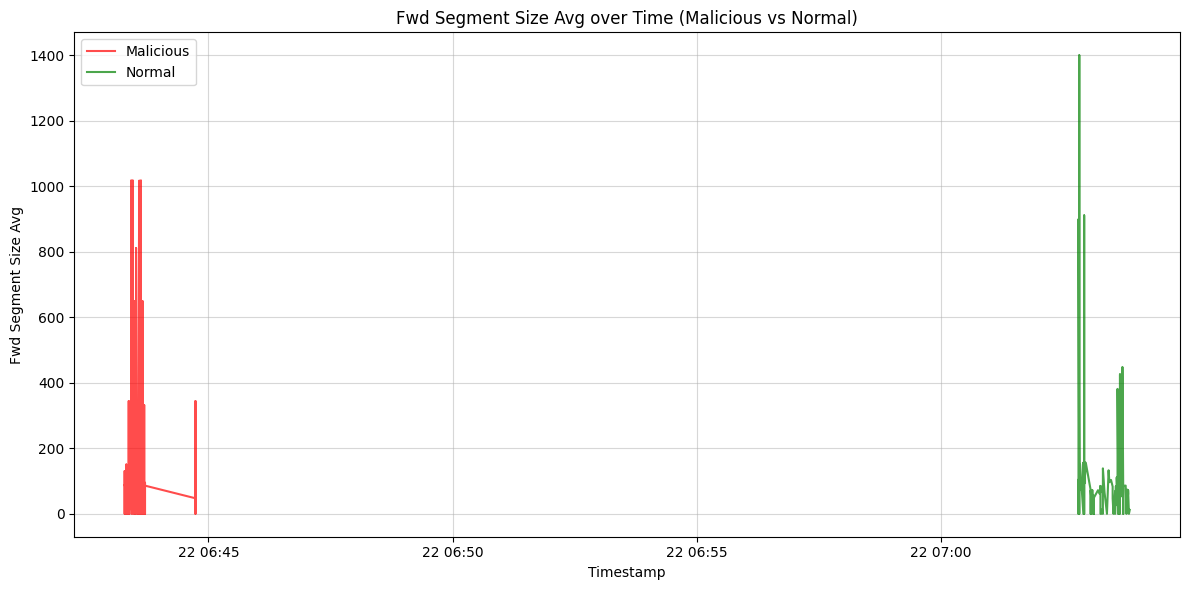

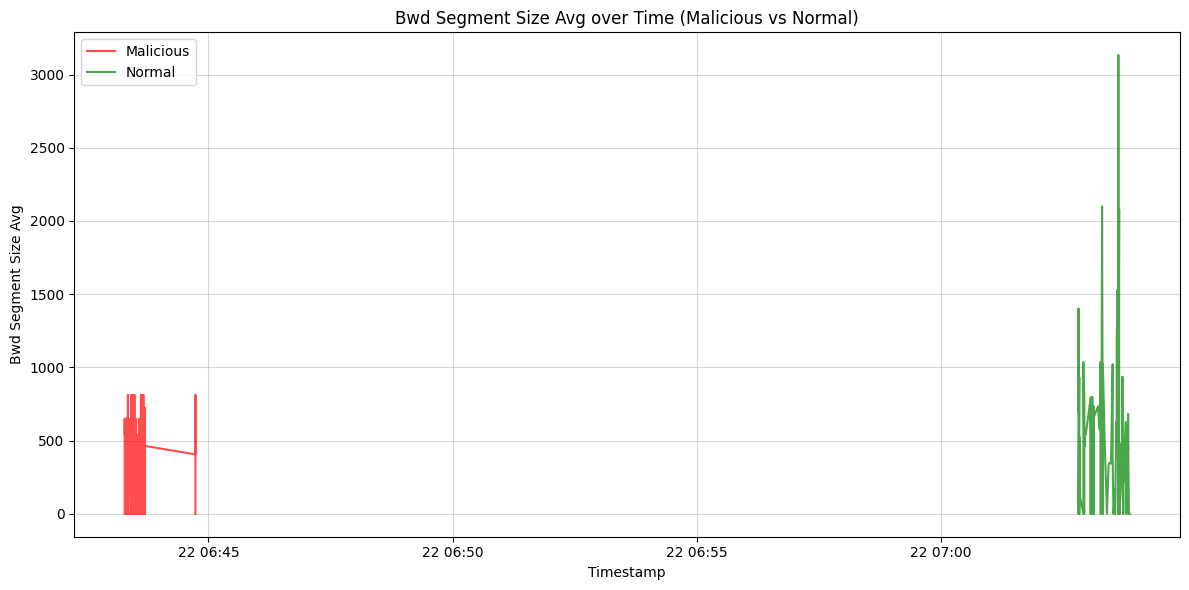

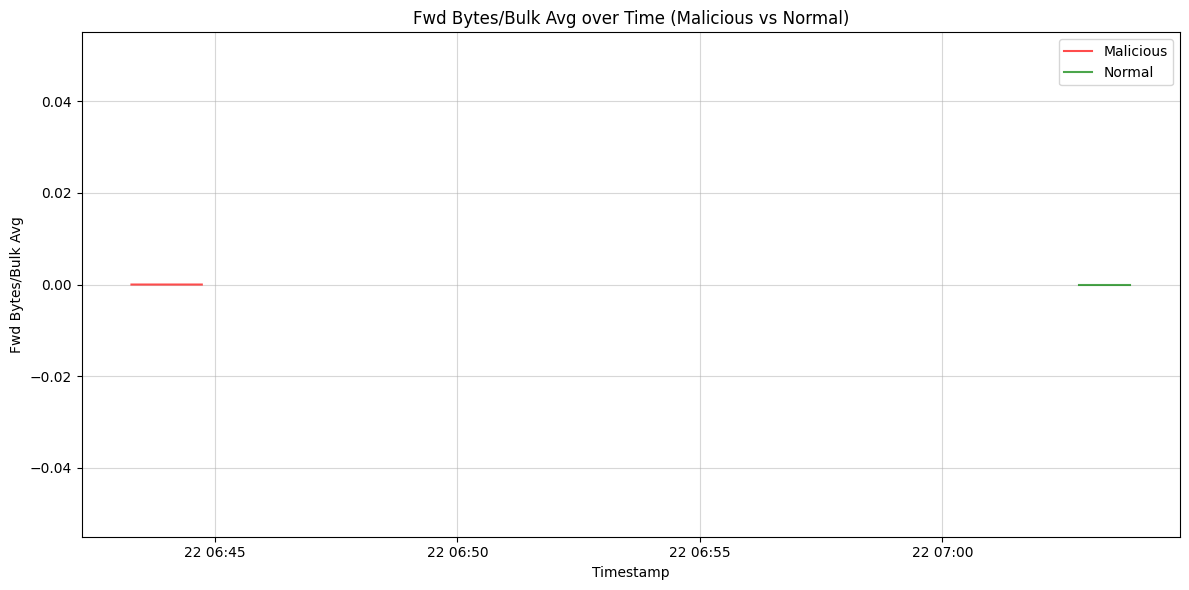

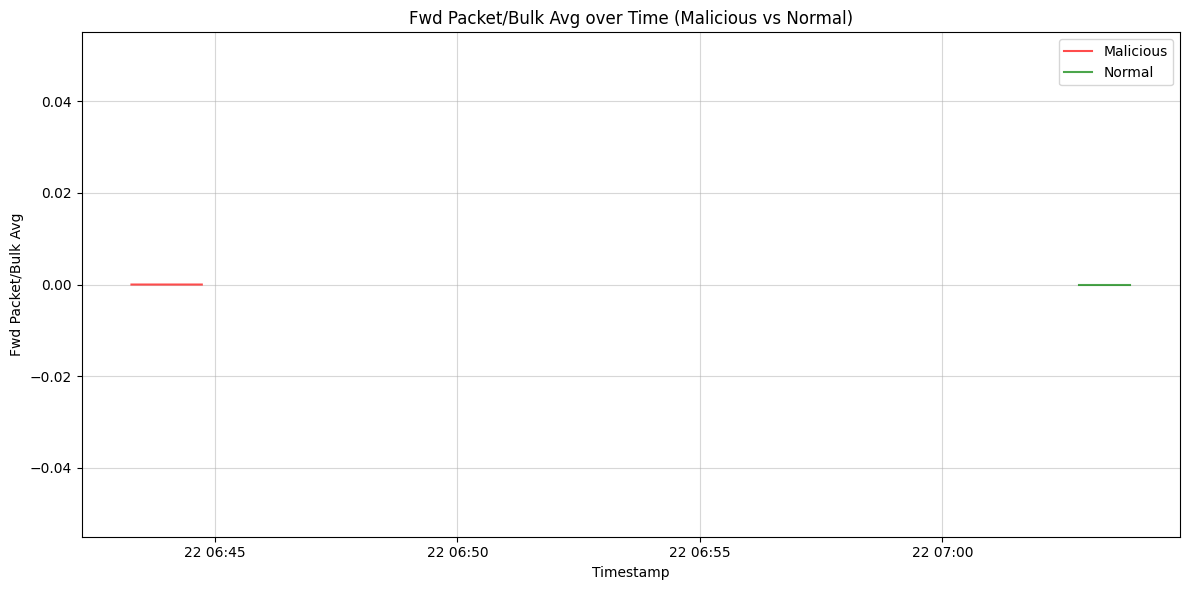

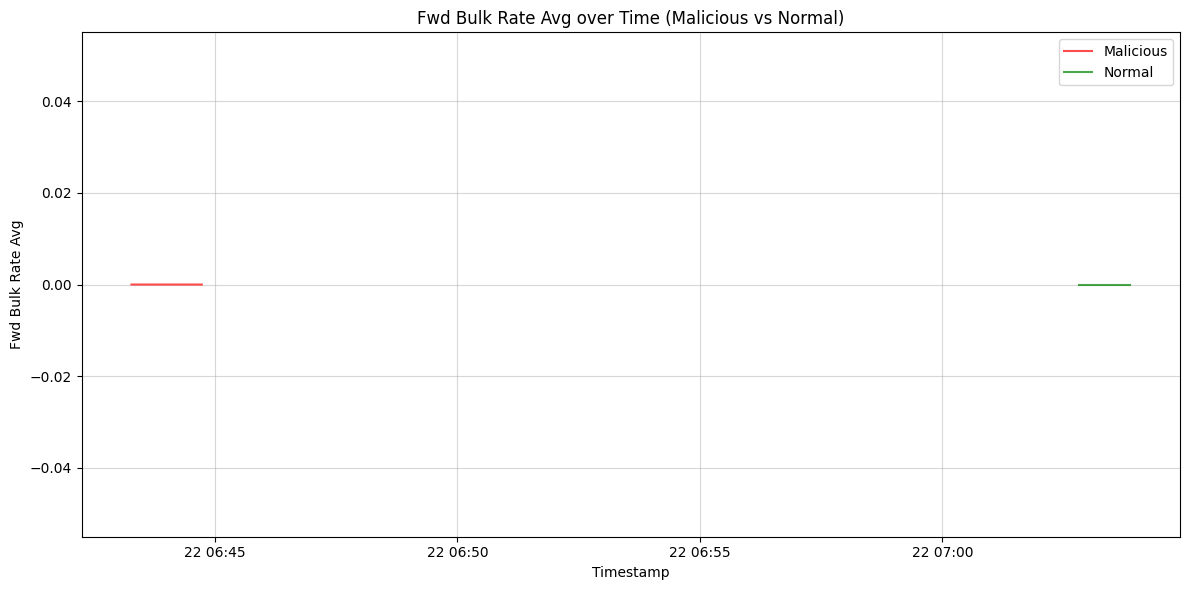

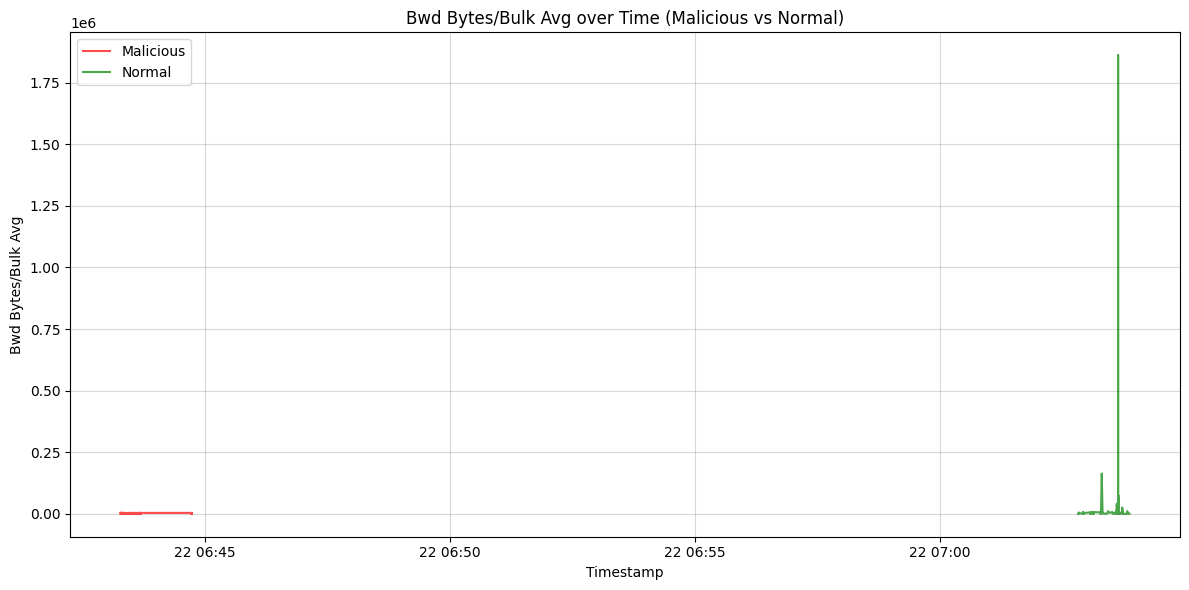

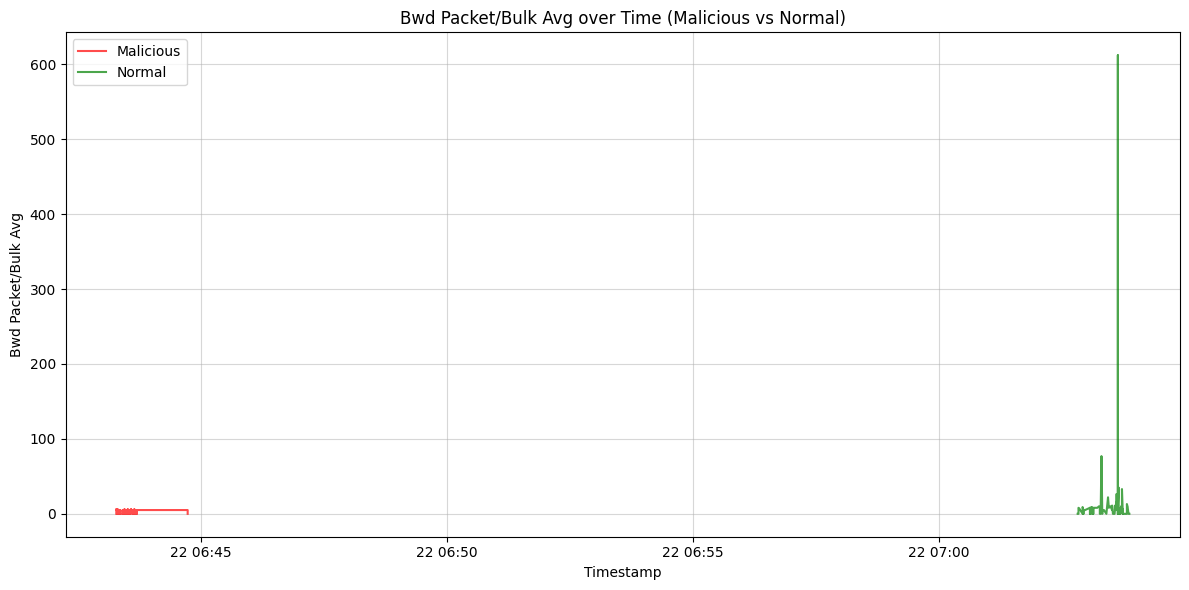

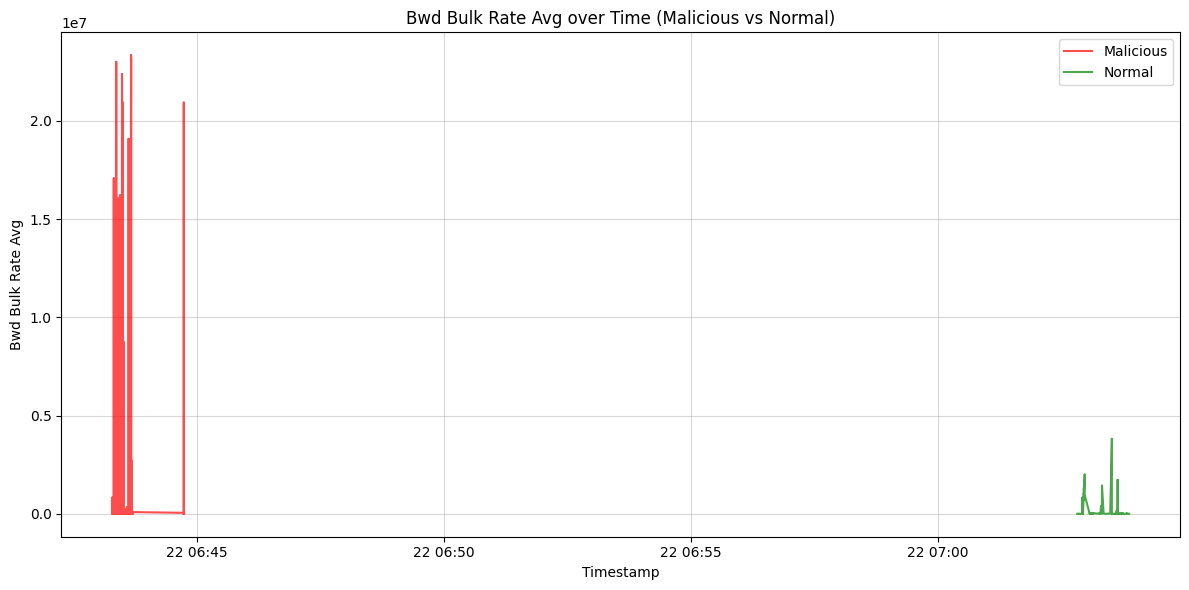

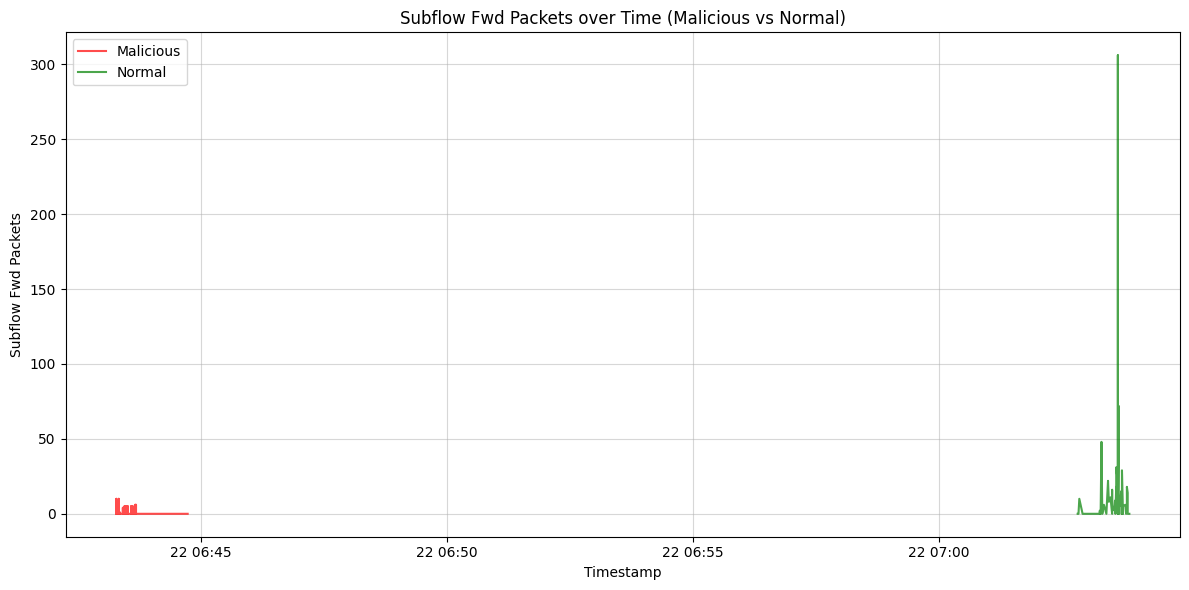

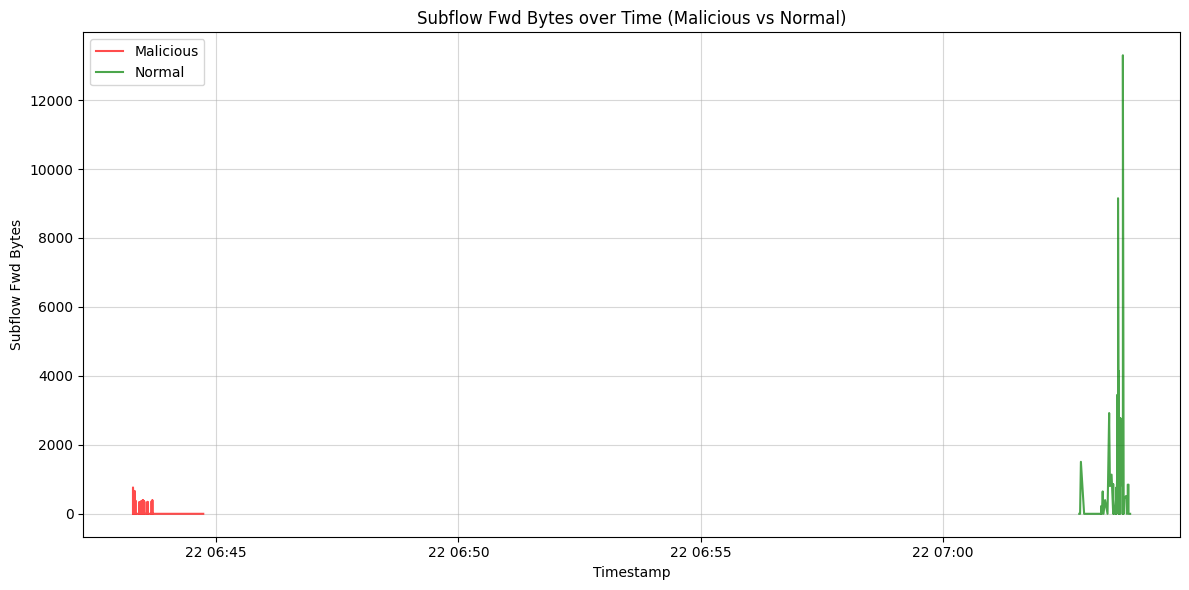

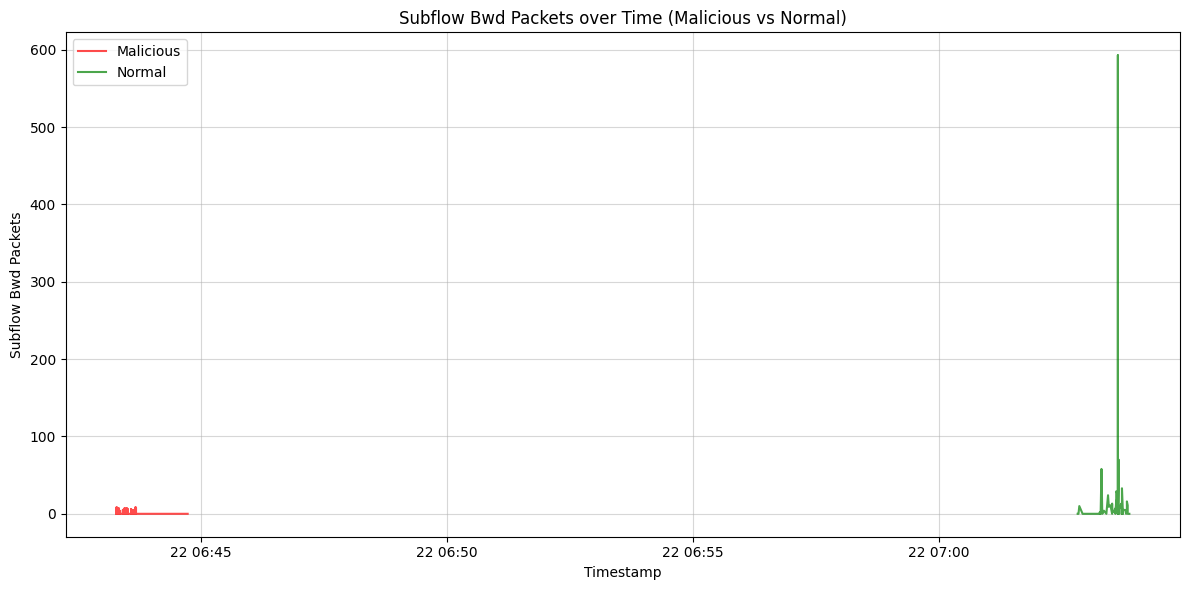

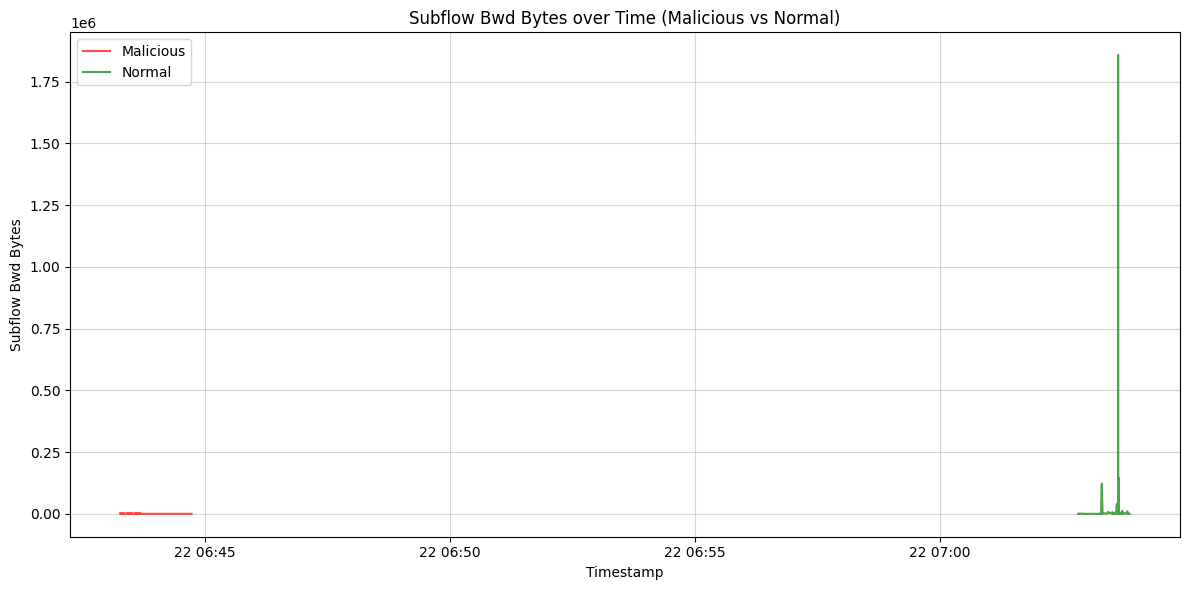

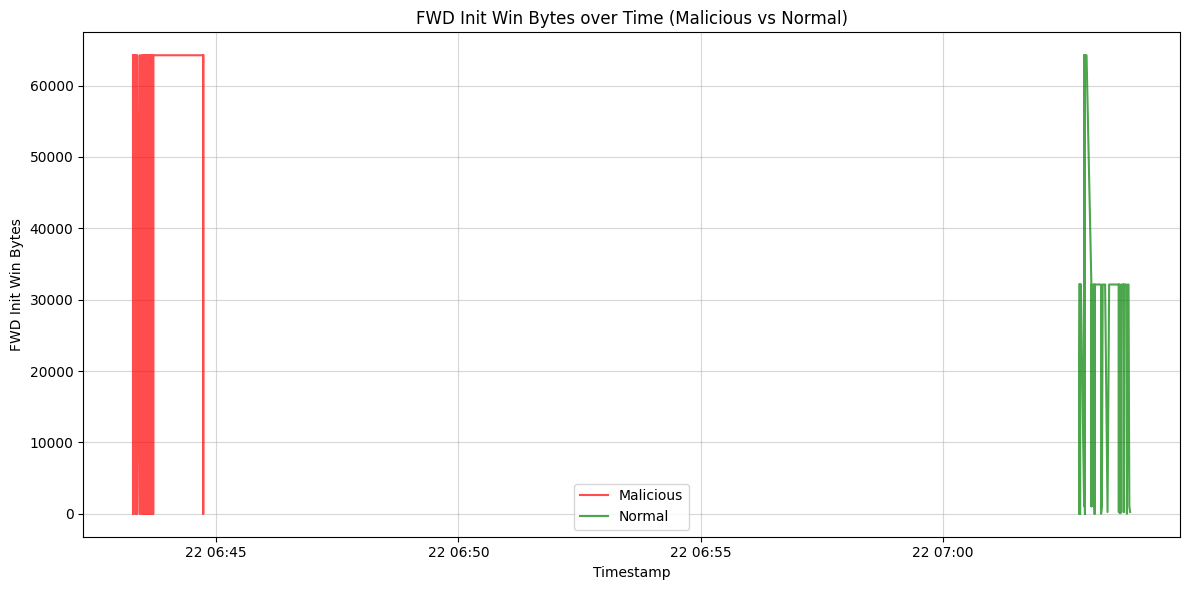

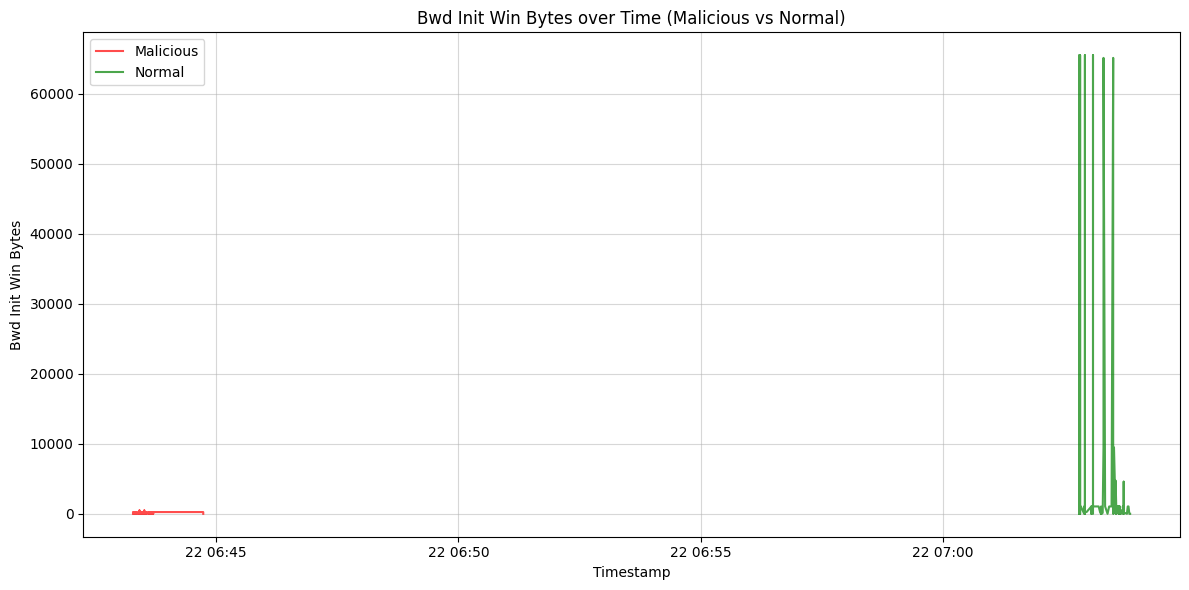

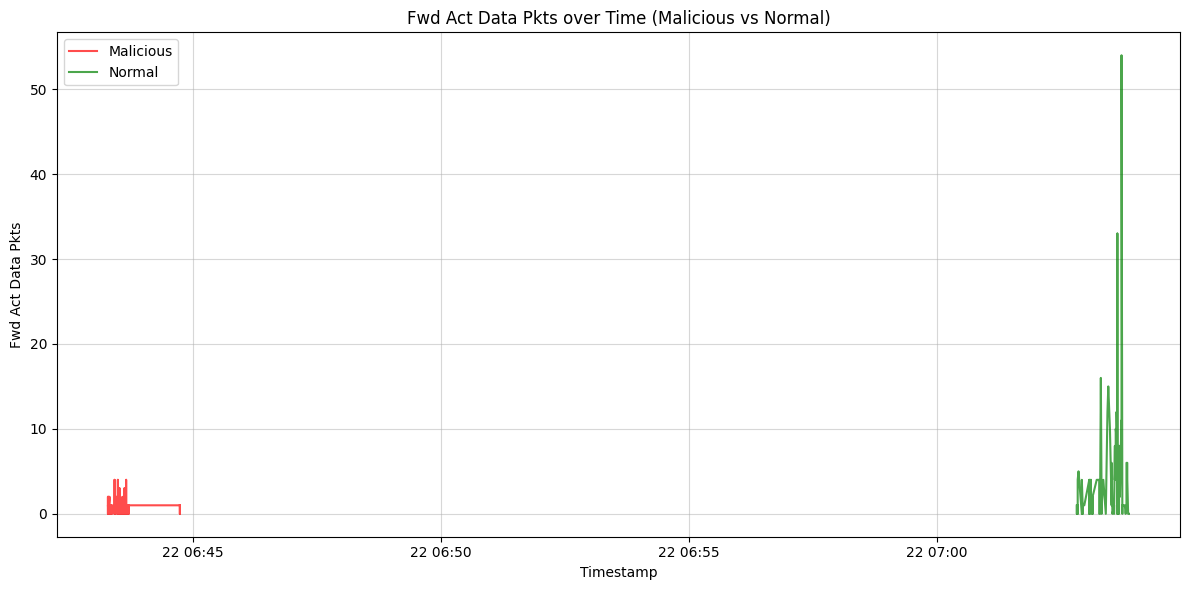

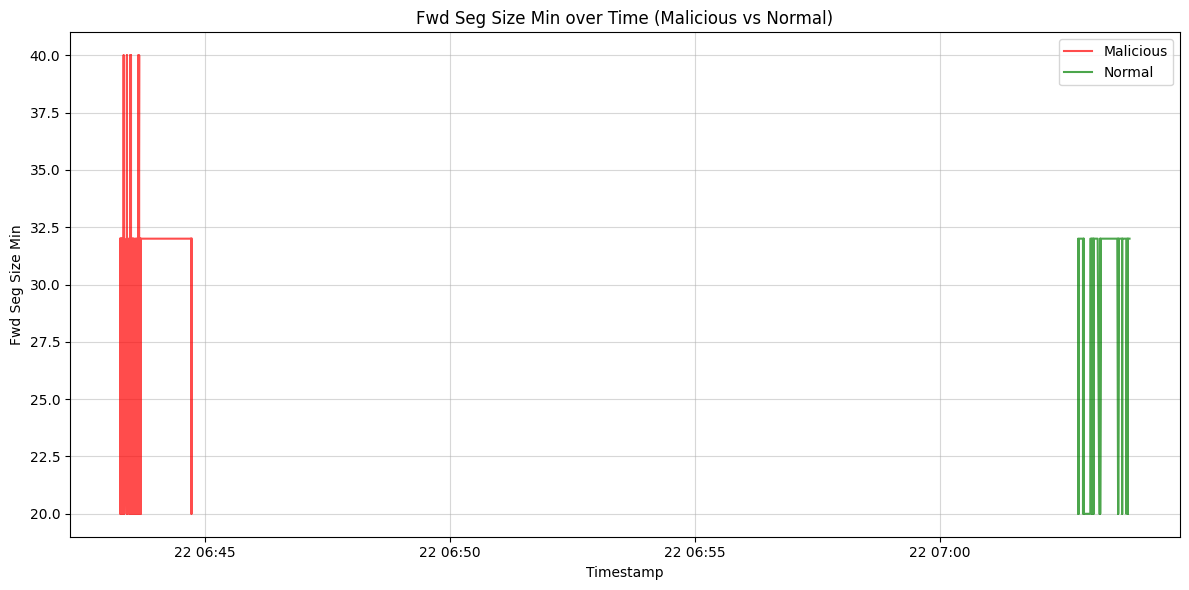

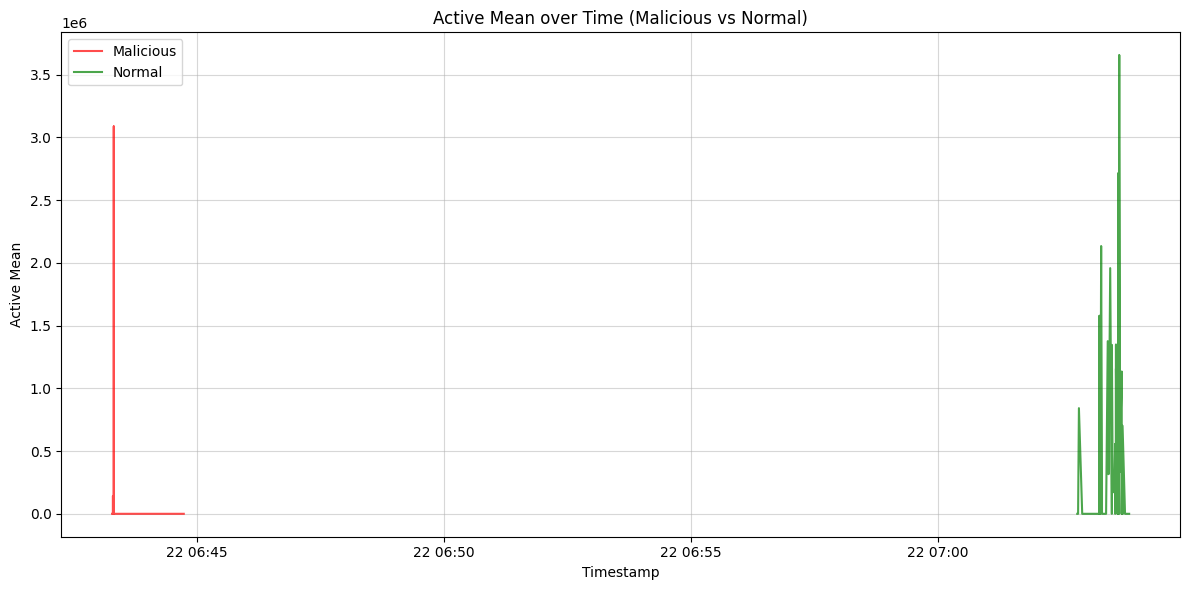

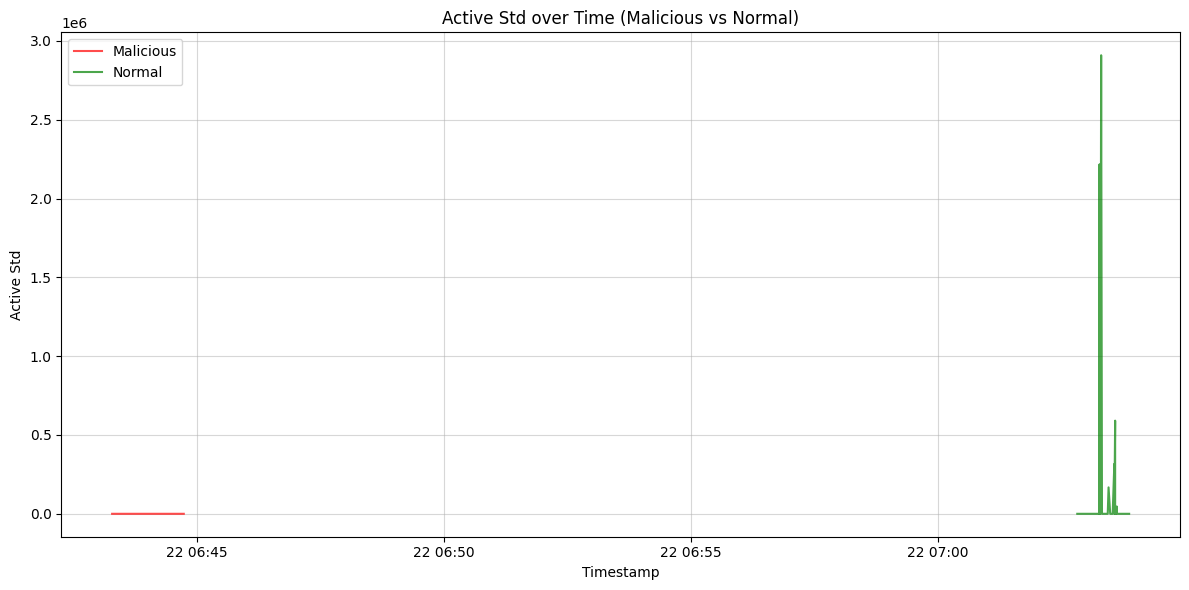

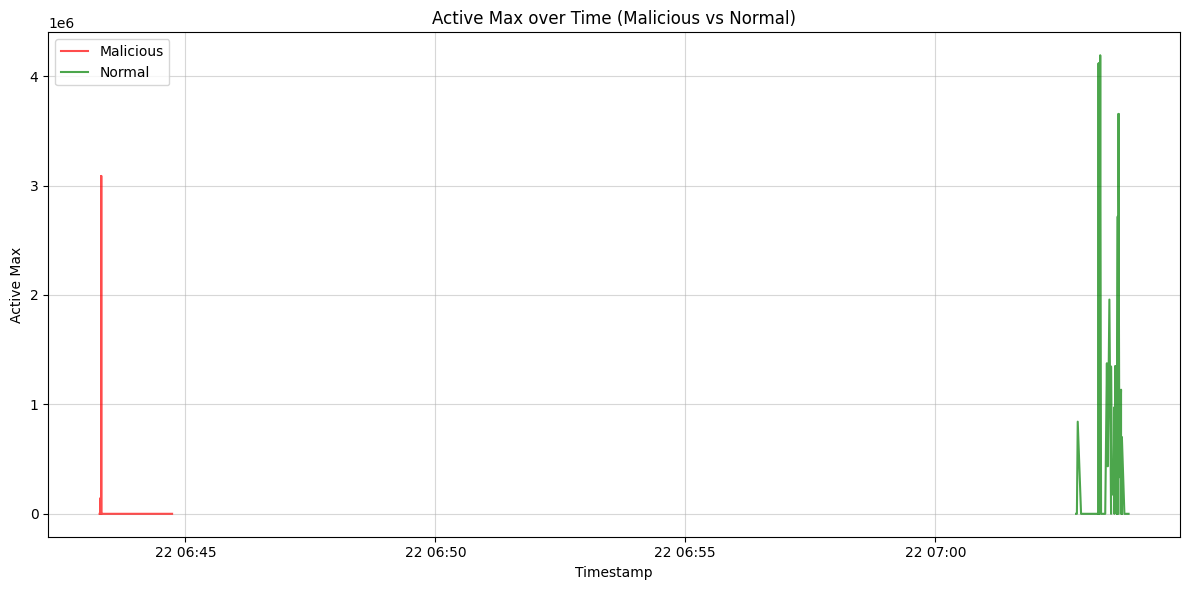

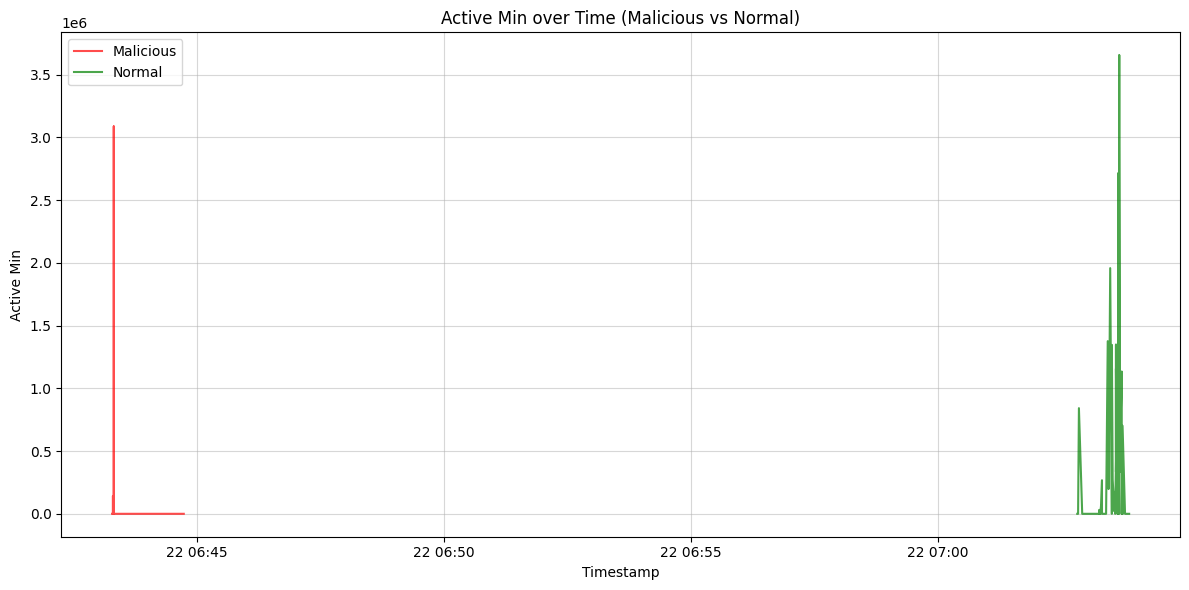

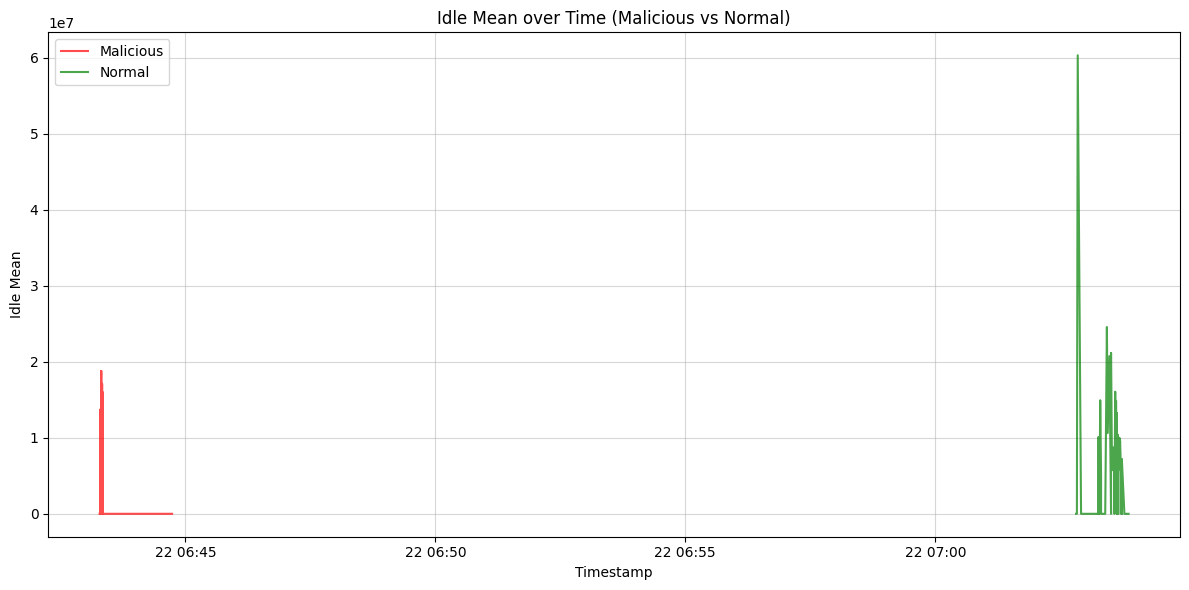

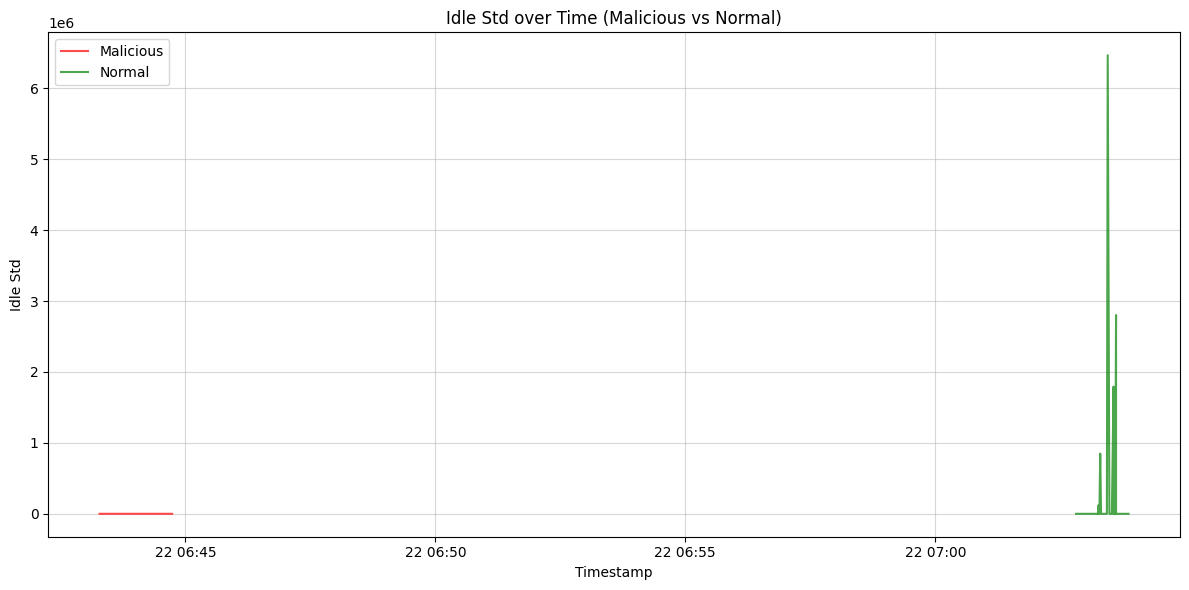

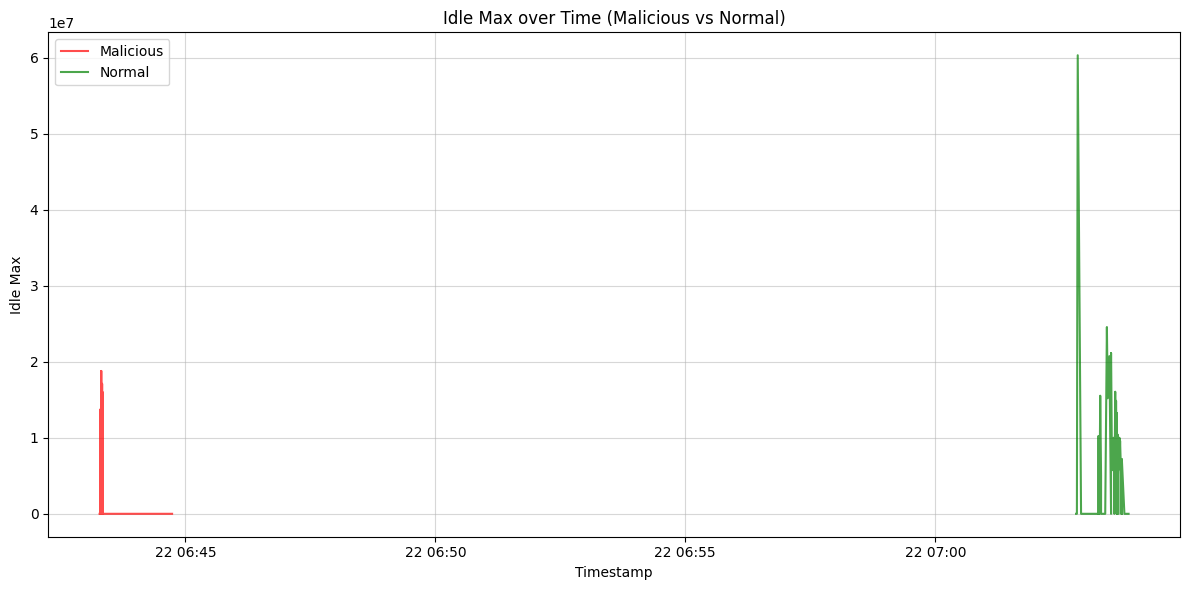

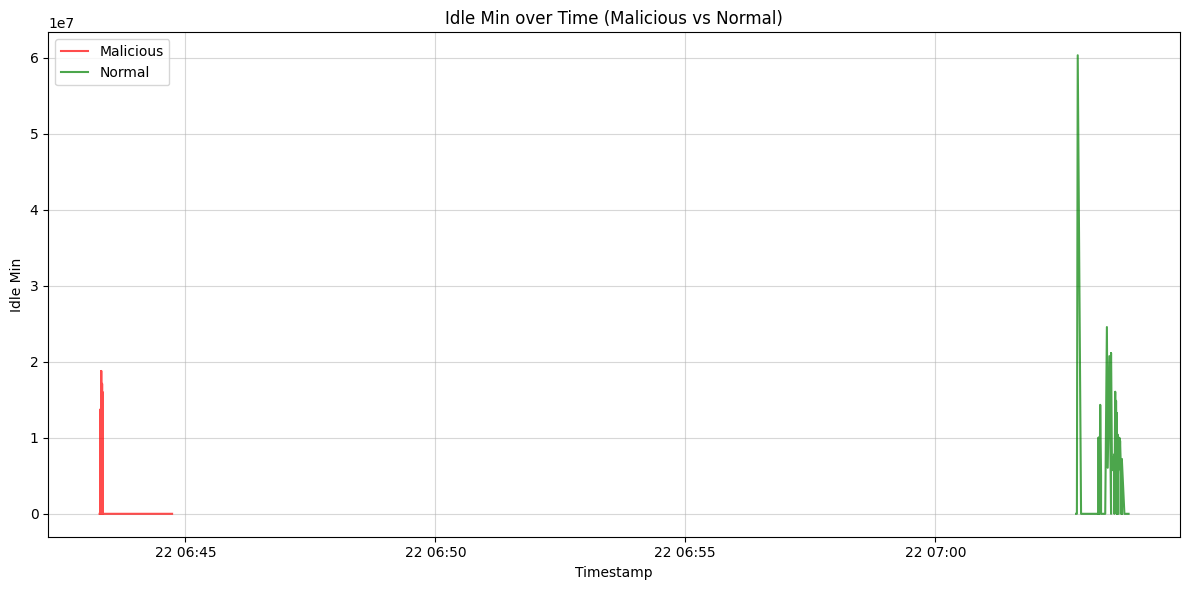

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load datasets
malicious_df = pd.read_csv('malicious_only.csv')
safe_df = pd.read_csv('safe_only.csv')

# Label datasets
malicious_df['Label'] = 'Malicious'
safe_df['Label'] = 'Normal'

# Combine datasets
combined_df = pd.concat([malicious_df, safe_df])

# Convert Timestamp column to datetime (update 'Timestamp' if necessary)
combined_df['Timestamp'] = pd.to_datetime(combined_df['Timestamp'])

# Sort data by Timestamp
combined_df.sort_values(by='Timestamp', inplace=True)

# Define explicit mappings for y-axis labels
label_mapping = {
    'Flow Duration': 'Flow Duration (seconds)',
    'Src Port': 'Source Port Number',
    'Dst Port': 'Destination Port Number',
    'Total Fwd Packets': 'Total Forward Packets',
    'Total Bwd Packets': 'Total Backward Packets',
    'Total Length of Fwd Packets': 'Forward Packets Length (Bytes)',
    'Total Length of Bwd Packets': 'Backward Packets Length (Bytes)',
    'Fwd Packet Length Max': 'Forward Packet Length Max (Bytes)',
    'Fwd Packet Length Min': 'Forward Packet Length Min (Bytes)',
    'Fwd Packet Length Mean': 'Forward Packet Length Mean (Bytes)',
    'Bwd Packet Length Max': 'Backward Packet Length Max (Bytes)',
    'Bwd Packet Length Min': 'Backward Packet Length Min (Bytes)',
    'Bwd Packet Length Mean': 'Backward Packet Length Mean (Bytes)',
    'Flow Bytes/s': 'Flow Bytes per second',
    'Flow Packets/s': 'Flow Packets per second',
    'Flow IAT Mean': 'Flow Interarrival Time Mean (ms)',
    # Add more mappings if necessary
}

# List features excluding Timestamp and Label
features_to_plot = combined_df.columns.drop(['Timestamp', 'Label'])

# Plotting with explicit axis labels
for feature in features_to_plot:
    plt.figure(figsize=(12, 6))

    # Malicious data
    malicious_data = combined_df[combined_df['Label'] == 'Malicious']
    plt.plot(malicious_data['Timestamp'], malicious_data[feature], color='red', label='Malicious', alpha=0.7)

    # Normal data
    normal_data = combined_df[combined_df['Label'] == 'Normal']
    plt.plot(normal_data['Timestamp'], normal_data[feature], color='green', label='Normal', alpha=0.7)

    # Explicit y-axis labeling
    ylabel = label_mapping.get(feature, feature)

    plt.title(f'{ylabel} over Time (Malicious vs Normal)')
    plt.xlabel('Timestamp')
    plt.ylabel(ylabel)

    plt.legend()
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
import joblib
import warnings

# Suppress XGBoost warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Function to replace infinite values with NaN (replaces the lambda)
def replace_inf_with_nan(x):
    return np.where(np.isinf(x), np.nan, x)

# Load labeled training data
df = pd.read_csv('labeled_data.csv')

# Drop unwanted columns
X = df.drop(['Label', 'Flow ID', 'Timestamp', 'Src IP', 'Dst IP', 'Src Port', 'Dst Port'], axis=1, errors='ignore')
y_raw = df['Label']

# Split data
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X, y_raw, test_size=0.20, stratify=y_raw, random_state=42
)

# Encode string labels to numeric
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train_raw)
y_test = label_encoder.transform(y_test_raw)

# Set XGBoost objective
num_classes = len(label_encoder.classes_)
if num_classes == 2:
    objective = 'binary:logistic'
    eval_metric = 'logloss'
else:
    objective = 'multi:softprob'
    eval_metric = 'mlogloss'

# Define XGBoost parameters
xgb_params = {
    'n_estimators': 100,
    'max_depth': 10,
    'learning_rate': 0.1,
    'use_label_encoder': False,
    'eval_metric': eval_metric,
    'objective': objective,
    'random_state': 42,
    'n_jobs': -1
}
if num_classes > 2:
    xgb_params['num_class'] = num_classes

# Preprocessing pipeline
cat_cols = ['Protocol']
num_cols = [c for c in X_train_raw.columns if c not in cat_cols]
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
    ('num', Pipeline([
        ('clip', FunctionTransformer(replace_inf_with_nan, validate=False)),
        ('impute', SimpleImputer(strategy='median'))
    ]), num_cols)
])

# Build training pipeline
train_pipeline = Pipeline([
    ('pre', preprocessor),
    ('xgb', XGBClassifier(**xgb_params))
])

# Train the model
train_pipeline.fit(X_train_raw, y_train)

# Save the trained model
joblib.dump(train_pipeline, 'attack.pkl')
print("✅ Trained model saved to 'attack.pkl'")

# ───────────────────────────────────────────────────────────
# Load model and predict on test.csv
# ───────────────────────────────────────────────────────────
print("\n🔄 Loading model for predictions...")
loaded_pipeline = joblib.load('attack.pkl')

# Evaluate loaded model on hold-out test set
y_pred = loaded_pipeline.predict(X_test_raw)
print("\n📊 Evaluation on Test Set:")
print("Number of features used for training:", loaded_pipeline.named_steps['pre'].transform(X_train_raw).shape[1])
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Load test data
test_df = pd.read_csv('test.csv')
test_features = test_df.drop(['Flow ID', 'Timestamp', 'Src IP', 'Dst IP', 'Src Port', 'Dst Port', 'Label'], axis=1, errors='ignore')

# Predict using loaded model
test_pred_numeric = loaded_pipeline.predict(test_features)
test_pred_label = label_encoder.inverse_transform(test_pred_numeric)
test_proba = loaded_pipeline.predict_proba(test_features).max(axis=1)

# Add predictions to DataFrame
test_df['Predicted_Label'] = test_pred_label
test_df['Confidence'] = test_proba

# Filter low-confidence predictions
filtered_df = test_df[test_df['Confidence'] >= 0.65]

# Summary
print("\n📈 Prediction Summary (Confidence ≥ 0.65):")
print(filtered_df['Predicted_Label'].value_counts())
print("\nPrediction Proportions (%):")
print((filtered_df['Predicted_Label'].value_counts(normalize=True) * 100).round(2))

# Save predictions
filtered_df.to_csv('other_data_labeled.csv', index=False)
print(f"\n✅ Filtered predictions saved to 'other_data_labeled.csv' (kept {len(filtered_df)} of {len(test_df)} rows)")

✅ Trained model saved to 'attack.pkl'

🔄 Loading model for predictions...

📊 Evaluation on Test Set:
Number of features used for training: 79
Classification Report:
               precision    recall  f1-score   support

   malicious       0.99      0.99      0.99       681
      normal       0.98      0.99      0.99       590

    accuracy                           0.99      1271
   macro avg       0.99      0.99      0.99      1271
weighted avg       0.99      0.99      0.99      1271

Confusion Matrix:
 [[671  10]
 [  4 586]]
Accuracy: 0.988985051140834

📈 Prediction Summary (Confidence ≥ 0.65):
Predicted_Label
malicious    1289
normal        335
Name: count, dtype: int64

Prediction Proportions (%):
Predicted_Label
malicious    79.37
normal       20.63
Name: proportion, dtype: float64

✅ Filtered predictions saved to 'other_data_labeled.csv' (kept 1624 of 1626 rows)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
# ───────────────────────────────────────────────────────────
# Load model and predict on test.csv
# ───────────────────────────────────────────────────────────
print("\n🔄 Loading model for predictions...")
loaded_pipeline = joblib.load('attack.pkl')

# Evaluate loaded model on hold-out test set
y_pred = loaded_pipeline.predict(X_test_raw)
print("\n📊 Evaluation on Test Set:")
print("Number of features used for training:", loaded_pipeline.named_steps['pre'].transform(X_train_raw).shape[1])
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Load test data
test_df = pd.read_csv('test.csv')
test_features = test_df.drop(['Flow ID', 'Timestamp', 'Src IP', 'Dst IP', 'Src Port', 'Dst Port', 'Label'], axis=1, errors='ignore')

# Predict using loaded model
test_pred_numeric = loaded_pipeline.predict(test_features)
test_pred_label = label_encoder.inverse_transform(test_pred_numeric)
test_proba = loaded_pipeline.predict_proba(test_features).max(axis=1)

# Add predictions to DataFrame
test_df['Predicted_Label'] = test_pred_label
test_df['Confidence'] = test_proba

# Filter low-confidence predictions
filtered_df = test_df[test_df['Confidence'] >= 0.65]

# Summary
print("\n📈 Prediction Summary (Confidence ≥ 0.65):")
print(filtered_df['Predicted_Label'].value_counts())
print("\nPrediction Proportions (%):")
print((filtered_df['Predicted_Label'].value_counts(normalize=True) * 100).round(2))

# Save predictions
filtered_df.to_csv('other_data_labeled.csv', index=False)
print(f"\n✅ Filtered predictions saved to 'other_data_labeled.csv' (kept {len(filtered_df)} of {len(test_df)} rows)")


🔄 Loading model for predictions...

📊 Evaluation on Test Set:
Number of features used for training: 79
Classification Report:
               precision    recall  f1-score   support

   malicious       0.99      0.99      0.99       681
      normal       0.98      0.99      0.99       590

    accuracy                           0.99      1271
   macro avg       0.99      0.99      0.99      1271
weighted avg       0.99      0.99      0.99      1271

Confusion Matrix:
 [[671  10]
 [  4 586]]
Accuracy: 0.988985051140834

📈 Prediction Summary (Confidence ≥ 0.65):
Predicted_Label
malicious    1289
normal        335
Name: count, dtype: int64

Prediction Proportions (%):
Predicted_Label
malicious    79.37
normal       20.63
Name: proportion, dtype: float64

✅ Filtered predictions saved to 'other_data_labeled.csv' (kept 1624 of 1626 rows)
